In [1]:
# ============================================================================
# WILDFIRE IGNITION PREDICTION WITH HPC PARALLELIZATION
# ============================================================================
# 
# PROJECT OVERVIEW:
# This notebook demonstrates High Performance Computing (HPC) techniques
# applied to wildfire prediction using meteorological data.
#
# KEY OBJECTIVES:
# 1. Process 9.5M rows of weather/fire data
# 2. Engineer temporal features using 60-day rolling windows
# 3. Demonstrate parallelization with Dask and Joblib
# 4. Train XGBoost model for fire prediction
# 5. Benchmark performance across different core counts
#
# RESOURCES:
# - 50 CPU cores available
# - 35 GB RAM
# - 14 hour time limit
#

In [2]:
# ============================================================================
# CELL 1: IMPORT LIBRARIES
# ============================================================================
# 
# WHY: Load all required packages upfront to avoid import errors later
# WHAT: 
# - pandas/numpy: Data manipulation
# - dask: Parallel data processing
# - joblib: Parallel feature engineering
# - xgboost: Machine learning model
# - sklearn: Model evaluation metrics
# - matplotlib: Visualizations
#
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parallel processing
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from joblib import Parallel, delayed

# Machine learning
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# Utilities
import time
import psutil
import warnings
warnings.filterwarnings('ignore')
# ============ ADDED THESE LINES TO SUPPRESS DASK LOGGING ============
import logging

# Suppress Dask distributed logging
logging.getLogger('distributed').setLevel(logging.ERROR)
logging.getLogger('distributed.scheduler').setLevel(logging.ERROR)
logging.getLogger('distributed.worker').setLevel(logging.ERROR)
logging.getLogger('distributed.core').setLevel(logging.ERROR)
logging.getLogger('distributed.nanny').setLevel(logging.ERROR)

# Also suppress warnings from Dask
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='distributed')


# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 Available RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"🖥️  Available Cores: {psutil.cpu_count()}")

✅ All libraries imported successfully!
📊 Available RAM: 186.8 GB
🖥️  Available Cores: 112


In [3]:
# ============================================================================
# CELL 2: CONFIGURATION & PARAMETERS
# ============================================================================
#
# WHY: Centralize all settings for easy adjustment
# WHAT: File paths, feature lists, core counts to test
#
# ============================================================================

# File path
CSV_PATH = "Wildfire_Dataset.csv"

# Features to keep (removes unnecessary columns to save memory)
ESSENTIAL_COLS = [
    'latitude', 'longitude', 'datetime', 'Wildfire',
    'erc', 'bi', 'fm100', 'fm1000', 'tmmx', 'tmmn',
    'vpd', 'rmax', 'rmin', 'pr'
]

# Meteorological variables for rolling features
# WHY: These are the most predictive weather/fuel conditions
ROLL_COLS = ['erc', 'bi', 'fm100', 'fm1000', 'tmmx', 'tmmn', 
             'vpd', 'rmax', 'rmin', 'pr']

# Core counts to benchmark
# WHY: Test different parallelization levels to measure speedup
CORES_TO_TEST = [1, 4, 8, 16, 32, 50]

# Sentinel values to remove (GRIDMET invalid data markers)
# WHY: These are placeholder values indicating missing/invalid data
SENTINELS = [32767, 32766, -32768]

print("✅ Configuration loaded")
print(f"📝 Will test with cores: {CORES_TO_TEST}")
print(f"🌡️  Rolling features for {len(ROLL_COLS)} variables")


✅ Configuration loaded
📝 Will test with cores: [1, 4, 8, 16, 32, 50]
🌡️  Rolling features for 10 variables


In [4]:
# ============================================================================
# CELL 3: DASK PARALLEL DATA LOADING
# ============================================================================
#
# WHY: Reading 9.5M rows takes time. Dask parallelizes CSV reading.
# HOW: Splits CSV into chunks, reads chunks in parallel
# BENEFIT: 4-8x faster than pandas for large files
#
# DECISION: Use Dask here because I/O operations parallelize well
#
# ============================================================================

print("\n" + "="*80)
print(" PARALLEL DATA LOADING WITH DASK ".center(80))
print("="*80)

def load_data_pandas():
    """Sequential loading with pandas (baseline)"""
    return pd.read_csv(CSV_PATH, usecols=ESSENTIAL_COLS)

def load_data_dask(n_workers=4):
    """Parallel loading with Dask - memory-safe version"""
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=2,  # Allow 2 threads per worker
        memory_limit='8GB',    # Larger memory per worker
        silence_logs=logging.ERROR,
        dashboard_address=None  # Disable dashboard to save memory
    )
    client = Client(cluster)
    
    # Read with larger blocksize to reduce overhead
    ddf = dd.read_csv(
        CSV_PATH,
        usecols=ESSENTIAL_COLS,
        blocksize='128MB'  # Larger blocks = fewer partitions
    )
    
    df = ddf.compute()
    
    client.close()
    cluster.close()
    
    return df

# Then call with only 4 workers
df_dask = load_data_dask(n_workers=4)

# Benchmark loading
print("\n🔄 Loading with Pandas (sequential)...")
start = time.time()
df_pandas = load_data_pandas()
pandas_time = time.time() - start
print(f"✅ Pandas: {pandas_time:.1f}s ({pandas_time/60:.2f} min)")

print("\n🔄 Loading with Dask (8 workers)...")
start = time.time()
df_dask = load_data_dask(n_workers=8)
dask_time = time.time() - start
print(f"✅ Dask: {dask_time:.1f}s ({dask_time/60:.2f} min)")

speedup_loading = pandas_time / dask_time
print(f"\n🚀 Speedup: {speedup_loading:.2f}x")

# Use Dask result for rest of notebook
df = df_dask
del df_pandas, df_dask  # Free memory

print(f"\n📊 Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")


                        PARALLEL DATA LOADING WITH DASK                         

🔄 Loading with Pandas (sequential)...
✅ Pandas: 10.3s (0.17 min)

🔄 Loading with Dask (8 workers)...
✅ Dask: 9.0s (0.15 min)

🚀 Speedup: 1.15x

📊 Dataset loaded: 9,509,925 rows × 14 columns
💾 Memory usage: 1197.6 MB


In [5]:
# ============================================================================
# CELL 4: DATA CLEANING - DATETIME & TARGET
# ============================================================================
#
# WHY: Need valid datetime for time-series operations and binary target
# WHAT: 
# - Convert 'datetime' string to datetime object
# - Convert 'Wildfire' from "Yes"/"No" to 1/0
# - Remove any invalid rows
#
# DECISION: Keep this sequential (minimal computation, not worth parallelizing)
#
# ============================================================================

print("\n" + "="*80)
print(" DATA CLEANING: DATETIME & TARGET ".center(80))
print("="*80)

# Convert datetime
print("🔄 Converting datetime column...")
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Clean Wildfire target variable
print("🔄 Cleaning target variable (Wildfire)...")
df['Wildfire'] = (
    df['Wildfire']
    .astype(str)
    .str.strip()
    .str.title()
)

# Keep only valid values
df = df[df['Wildfire'].isin(['Yes', 'No'])].copy()

# Convert to binary (0/1)
df['Wildfire'] = (df['Wildfire'] == 'Yes').astype(int)

# Drop rows with missing critical values
df = df.dropna(subset=['datetime', 'Wildfire']).reset_index(drop=True)

print(f"✅ Datetime converted")
print(f"✅ Target variable cleaned")
print(f"📊 Shape after cleaning: {df.shape}")
print(f"🔥 Fire rate: {df['Wildfire'].mean():.2%}")


                        DATA CLEANING: DATETIME & TARGET                        
🔄 Converting datetime column...
🔄 Cleaning target variable (Wildfire)...
✅ Datetime converted
✅ Target variable cleaned
📊 Shape after cleaning: (9509925, 14)
🔥 Fire rate: 5.28%


In [6]:
# ============================================================================
# CELL 5: REMOVE SENTINEL VALUES
# ============================================================================
#
# WHY: GRIDMET uses special codes (32767, etc.) for missing data
# WHAT: Replace these with NaN so they don't corrupt statistics
#
# DECISION: These are rare (~0.3% of values), so sequential is fine
#
# ============================================================================

print("\n" + "="*80)
print(" REMOVING SENTINEL VALUES ".center(80))
print("="*80)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"🔄 Checking {len(numeric_cols)} numeric columns for sentinels...")
sentinel_counts = {}

for col in numeric_cols:
    count = df[col].isin(SENTINELS).sum()
    if count > 0:
        sentinel_counts[col] = count
    # Replace with NaN
    df[col] = df[col].replace(SENTINELS, np.nan)

if sentinel_counts:
    print("\n✅ Sentinel values found and replaced:")
    for col, count in sorted(sentinel_counts.items(), key=lambda x: -x[1])[:5]:
        print(f"   {col}: {count:,} values")
else:
    print("✅ No sentinel values found")

print(f"\n📊 Dataset shape: {df.shape}")



                            REMOVING SENTINEL VALUES                            
🔄 Checking 13 numeric columns for sentinels...

✅ Sentinel values found and replaced:
   pr: 25,725 values
   rmax: 25,725 values
   rmin: 25,725 values
   tmmn: 25,725 values
   tmmx: 25,725 values

📊 Dataset shape: (9509925, 14)


In [7]:
# ============================================================================
# CELL 6: BASIC FEATURE ENGINEERING
# ============================================================================
#
# WHY: Extract temporal features (year, month, etc.) for modeling
# WHAT: Add year, month, day_of_year from datetime
#
# DECISION: Sequential (very fast operation, <1 second)
#
# ============================================================================

print("\n" + "="*80)
print(" BASIC FEATURE ENGINEERING ".center(80))
print("="*80)

print("🔄 Extracting temporal features...")
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayofyear'] = df['datetime'].dt.dayofyear

print(f"✅ Added 3 temporal features: year, month, dayofyear")
print(f"📊 Shape: {df.shape}")
print(f"📅 Date range: {df['datetime'].min()} to {df['datetime'].max()}")



                           BASIC FEATURE ENGINEERING                            
🔄 Extracting temporal features...
✅ Added 3 temporal features: year, month, dayofyear
📊 Shape: (9509925, 17)
📅 Date range: 2013-12-31 00:00:00 to 2025-04-13 00:00:00


In [8]:
# ============================================================================
# CELL 7: IMPROVED TIME-AWARE TRAIN/VAL/TEST SPLIT
# ============================================================================
#
# WHY: Cannot use random split for time-series (would cause data leakage)
# HOW: Split chronologically BUT with balanced sampling
#
# IMPROVEMENT FROM PREVIOUS VERSION:
# - Old approach: Simple year-based split caused severe class imbalance
#   (Train: 4% fires, Test: 18% fires)
# - New approach: Stratified temporal split maintains more balanced distribution
#
# DECISION: 
# - Train: 2014-2021 (8 years) - Keep ALL fire events + sample non-fires
# - Val:   2022-2023 (2 years) - Keep ALL fire events + sample non-fires  
# - Test:  2024-2025 (2 years) - Keep ALL data (test real distribution)
#
# ============================================================================

print("\n" + "="*80)
print(" IMPROVED TIME-AWARE TRAIN/VALIDATION/TEST SPLIT ".center(80))
print("="*80)

print("Original year distribution:")
print(df['year'].value_counts().sort_index())

# Strategy: Keep ALL fires, but sample non-fires to reduce extreme imbalance
# This reduces dataset size AND improves class balance for training

def create_balanced_split(df_period, target_fire_rate=0.15, keep_all_fires=True):
    """
    Create a more balanced split by sampling non-fire events
    
    Args:
        df_period: DataFrame for time period
        target_fire_rate: Desired fire rate (default 15%)
        keep_all_fires: Keep all fire events (default True)
    
    Returns:
        Balanced DataFrame
    """
    fires = df_period[df_period['Wildfire'] == 1]
    no_fires = df_period[df_period['Wildfire'] == 0]
    
    if keep_all_fires:
        # Calculate how many no-fires to keep for target rate
        n_fires = len(fires)
        n_no_fires_needed = int(n_fires * (1 - target_fire_rate) / target_fire_rate)
        n_no_fires_needed = min(n_no_fires_needed, len(no_fires))
        
        # Sample no-fires
        no_fires_sample = no_fires.sample(n=n_no_fires_needed, random_state=42)
        
        # Combine
        result = pd.concat([fires, no_fires_sample], ignore_index=True)
        return result.sort_values(['latitude', 'longitude', 'datetime']).reset_index(drop=True)
    else:
        return df_period

# Create year-based masks
train_years = (df['year'] >= 2014) & (df['year'] <= 2021)
val_years = (df['year'] >= 2022) & (df['year'] <= 2023)
test_years = df['year'] >= 2024

# Apply splits with balancing
print("\n📊 Creating balanced splits...")

# Train: Balance to 15% fire rate (reduces size, improves training)
df_train_raw = df.loc[train_years].copy()
df_train = create_balanced_split(df_train_raw, target_fire_rate=0.15)
print(f"Train: {len(df_train_raw):,} → {len(df_train):,} rows (balanced)")

# Val: Balance to 15% fire rate
df_val_raw = df.loc[val_years].copy()
df_val = create_balanced_split(df_val_raw, target_fire_rate=0.15)
print(f"Val:   {len(df_val_raw):,} → {len(df_val):,} rows (balanced)")

# Test: Keep original distribution (test on real-world scenario)
df_test = df.loc[test_years].copy()
print(f"Test:  {len(df_test):,} rows (original distribution)")

# Sort by location and time (CRITICAL for rolling features)
df_train = df_train.sort_values(['latitude', 'longitude', 'datetime']).reset_index(drop=True)
df_val = df_val.sort_values(['latitude', 'longitude', 'datetime']).reset_index(drop=True)
df_test = df_test.sort_values(['latitude', 'longitude', 'datetime']).reset_index(drop=True)

def summarize_split(name, split_df):
    n = len(split_df)
    fire_rate = split_df['Wildfire'].mean()
    n_locations = split_df[['latitude', 'longitude']].drop_duplicates().shape[0]
    print(f"{name:8} {n:>10,} rows | Fire rate: {fire_rate:>6.1%} | Locations: {n_locations:,}")

print("\n📊 Final Split Summary:")
summarize_split("Train:", df_train)
summarize_split("Val:", df_val)
summarize_split("Test:", df_test)

# Free memory
del df
print("\n✅ Splits created and sorted (ready for rolling features)")
print("💡 Benefits: Faster training, better class balance, reduced memory usage")


                IMPROVED TIME-AWARE TRAIN/VALIDATION/TEST SPLIT                 
Original year distribution:
year
2013         49
2014    1213318
2015    1240064
2016    1160796
2017    1080744
2018     970501
2019     875890
2020     799530
2021     718859
2022     617160
2023     491430
2024     322374
2025      19210
Name: count, dtype: int64

📊 Creating balanced splits...
Train: 8,059,702 → 2,183,440 rows (balanced)
Val:   1,108,590 → 742,340 rows (balanced)
Test:  341,584 rows (original distribution)

📊 Final Split Summary:
Train:    2,183,440 rows | Fire rate:  15.0% | Locations: 31,407
Val:        742,340 rows | Fire rate:  15.0% | Locations: 10,971
Test:       341,584 rows | Fire rate:  18.5% | Locations: 4,726

✅ Splits created and sorted (ready for rolling features)
💡 Benefits: Faster training, better class balance, reduced memory usage


In [9]:
# ============================================================================
# CELL 8: ROLLING FEATURE FUNCTION DEFINITION
# ============================================================================
#
# WHY: Define the computationally expensive operation we'll parallelize
# WHAT: For each location, compute 60-day rolling statistics
#
# EXPLANATION:
# - Rolling mean: Average conditions over past 60 days
# - Rolling std: Variability (high std = rapidly changing conditions)
# - Rolling max/min: Extreme values in recent history
# - Lag features: Conditions 7 and 30 days ago
#
# WHY 60 DAYS: Fire risk accumulates over weeks of dry weather
#
# ============================================================================

print("\n" + "="*80)
print(" DEFINING ROLLING FEATURE FUNCTION ".center(80))
print("="*80)

def add_60day_features(group: pd.DataFrame) -> pd.DataFrame:
    """
    Compute 60-day rolling features for a single location's time series.
    
    This function processes ONE location (lat/lon pair) at a time.
    It computes rolling statistics that capture temporal patterns
    in weather conditions leading up to potential fire events.
    
    Parameters:
    -----------
    group : DataFrame
        Time series data for a single location (already sorted by date)
    
    Returns:
    --------
    DataFrame with original columns + 60 rolling features
    
    Features created (for each of 10 variables):
    - roll60_mean: Average over past 60 days
    - roll60_std:  Variability over past 60 days  
    - roll60_max:  Maximum in past 60 days
    - roll60_min:  Minimum in past 60 days
    - lag7:        Value from 7 days ago
    - lag30:       Value from 30 days ago
    """
    # Ensure chronological order
    group = group.sort_values('datetime').copy()
    
    # For each meteorological variable
    for col in ROLL_COLS:
        if col not in group.columns:
            continue
        
        # 60-day rolling statistics
        # min_periods=1 allows computation even with <60 days of data
        rolling = group[col].rolling(window=60, min_periods=1)
        group[f'{col}_roll60_mean'] = rolling.mean()
        group[f'{col}_roll60_std'] = rolling.std()
        group[f'{col}_roll60_max'] = rolling.max()
        group[f'{col}_roll60_min'] = rolling.min()
        
        # Lag features (historical values)
        group[f'{col}_lag7'] = group[col].shift(7)
        group[f'{col}_lag30'] = group[col].shift(30)
    
    return group

print(f"✅ Rolling feature function defined")
print(f"📊 Variables to process: {len(ROLL_COLS)}")
print(f"📈 Features per variable: 6 (4 rolling + 2 lag)")
print(f"🎯 Total new features: {len(ROLL_COLS) * 6}")

print(f"\n💡 Why this is computationally expensive:")
print(f"   • Must process each location separately")
print(f"   • {len(df_train[['latitude','longitude']].drop_duplicates()):,} unique locations in training set")
print(f"   • Each rolling window scans backwards 60 days")
print(f"   • Total operations: billions")



                       DEFINING ROLLING FEATURE FUNCTION                        
✅ Rolling feature function defined
📊 Variables to process: 10
📈 Features per variable: 6 (4 rolling + 2 lag)
🎯 Total new features: 60

💡 Why this is computationally expensive:
   • Must process each location separately
   • 31,407 unique locations in training set
   • Each rolling window scans backwards 60 days
   • Total operations: billions


In [10]:
# ============================================================================
# CELL 9: IMPROVED JOBLIB PARALLEL ROLLING FEATURES
# ============================================================================
#
# WHY: Rolling features are the main computational bottleneck
# HOW: Split locations across cores with BETTER CHUNKING
#
# IMPROVEMENT FROM PREVIOUS VERSION:
# - Old: Split locations evenly (caused load imbalance)
# - New: Chunk by estimated workload (location × num_rows)
#
# KEY INSIGHT:
# - Locations have varying time series lengths (50-300 days)
# - Equal location split ≠ equal work distribution
# - Solution: Weight chunks by total rows, not location count
#
# ============================================================================

print("\n" + "="*80)
print(" IMPROVED JOBLIB PARALLELIZATION ".center(80))
print("="*80)

def compute_features_sequential(df_input: pd.DataFrame) -> pd.DataFrame:
    """
    Sequential baseline: Process all locations one by one.
    """
    return (
        df_input
        .groupby(['latitude', 'longitude'], group_keys=False)
        .apply(add_60day_features, include_groups=False)
        .reset_index(drop=True)
    )

def compute_features_parallel_improved(df_input: pd.DataFrame, n_cores: int) -> pd.DataFrame:
    """
    IMPROVED parallel version with workload-balanced chunking.
    
    Key improvement: Balance by TOTAL ROWS, not just location count
    This prevents some cores from getting all the large time series.
    """
    # Get location sizes (number of rows per location)
    location_sizes = df_input.groupby(['latitude', 'longitude']).size().reset_index(name='n_rows')
    location_sizes = location_sizes.sort_values('n_rows', ascending=False)  # Largest first
    
    n_locations = len(location_sizes)
    total_rows = location_sizes['n_rows'].sum()
    target_rows_per_chunk = total_rows / n_cores
    
    print(f"  → Splitting {n_locations:,} locations across {n_cores} cores")
    print(f"  → Total rows: {total_rows:,}")
    print(f"  → Target rows/core: {int(target_rows_per_chunk):,}")
    
    # Create balanced chunks
    chunks = []
    current_chunk = []
    current_chunk_rows = 0
    
    for idx, row in location_sizes.iterrows():
        current_chunk.append((row['latitude'], row['longitude']))
        current_chunk_rows += row['n_rows']
        
        # If chunk is large enough, start new chunk
        if current_chunk_rows >= target_rows_per_chunk and len(chunks) < n_cores - 1:
            chunks.append(pd.DataFrame(current_chunk, columns=['latitude', 'longitude']))
            current_chunk = []
            current_chunk_rows = 0
    
    # Add remaining locations to last chunk
    if current_chunk:
        chunks.append(pd.DataFrame(current_chunk, columns=['latitude', 'longitude']))
    
    # Verify chunk distribution
    chunk_sizes = [len(c) for c in chunks]
    print(f"  → Chunks: {len(chunks)} (locations per chunk: {min(chunk_sizes)}-{max(chunk_sizes)})")
    
    def process_chunk(chunk_idx, chunk_locs):
        """Process one chunk of locations"""
        # Get all rows for these locations
        chunk_data = df_input.merge(
            chunk_locs,
            on=['latitude', 'longitude'],
            how='inner'
        )
        
        # Apply rolling features
        result = (chunk_data
                  .groupby(['latitude', 'longitude'], group_keys=False)
                  .apply(add_60day_features, include_groups=False))
        
        return result
    
    # Execute in parallel
    results = Parallel(n_jobs=n_cores, verbose=0)(
        delayed(process_chunk)(i, chunk)
        for i, chunk in enumerate(chunks)
    )
    
    return pd.concat(results, ignore_index=True)

def benchmark_rolling(df_input: pd.DataFrame, n_cores: int):
    """Time the rolling feature generation"""
    start = time.time()
    
    if n_cores == 1:
        df_result = compute_features_sequential(df_input)
    else:
        df_result = compute_features_parallel_improved(df_input, n_cores)
    
    elapsed = time.time() - start
    return df_result, elapsed

print("✅ IMPROVED parallelization functions defined")
print("📝 Strategy: Workload-balanced chunking (by row count)")
print("🎯 Goal: Better load balancing → higher efficiency")



                        IMPROVED JOBLIB PARALLELIZATION                         
✅ IMPROVED parallelization functions defined
📝 Strategy: Workload-balanced chunking (by row count)
🎯 Goal: Better load balancing → higher efficiency


In [11]:
# ============================================================================
# CELL 10: RUN JOBLIB ROLLING FEATURE BENCHMARK
# ============================================================================
#
# WHY: This is the main HPC demonstration
# WHAT: Test rolling feature generation with 1, 4, 8, 16, 32, 50 cores
#
# EXPECTED TIME:
# - 1 core: ~10-15 minutes (baseline)
# - 50 cores: Depends on overhead (we'll see!)
#
# NOTE: First run (1 core) will take longest. Be patient!
#
# ============================================================================

print("\n" + "="*80)
print(" HPC BENCHMARK: ROLLING FEATURE GENERATION ".center(80))
print("="*80)

n_train_locs = df_train[['latitude', 'longitude']].drop_duplicates().shape[0]

print(f"\n📊 Dataset: {len(df_train):,} rows")
print(f"📍 Locations: {n_train_locs:,}")
print(f"🌡️  Features: {len(ROLL_COLS)} variables → {len(ROLL_COLS)*6} new features")
print(f"⏱️  Window: 60-day rolling statistics")
print(f"\n{'='*80}\n")

results_joblib = {}
df_train_with_features = None

for n_cores in CORES_TO_TEST:
    print(f"🔄 Testing with {n_cores} core{'s' if n_cores > 1 else ''}...")
    
    if n_cores == 1:
        print(f"   ⚠️  This will take ~10-15 minutes (baseline measurement)")
    
    df_result, elapsed = benchmark_rolling(df_train, n_cores)
    
    results_joblib[n_cores] = {'time': elapsed}
    print(f"✅ {n_cores} cores: {elapsed:.1f}s ({elapsed/60:.2f} min)\n")
    
    # Save 1-core result as canonical features
    if n_cores == 1:
        df_train_with_features = df_result.copy()
        print(f"   📊 Feature shape: {df_train_with_features.shape}\n")

print(f"{'='*80}")
print(f"✅ Benchmark complete!")
print(f"✅ Canonical training features saved: {df_train_with_features.shape}")
print(f"{'='*80}")


                   HPC BENCHMARK: ROLLING FEATURE GENERATION                    

📊 Dataset: 2,183,440 rows
📍 Locations: 31,407
🌡️  Features: 10 variables → 60 new features
⏱️  Window: 60-day rolling statistics


🔄 Testing with 1 core...
   ⚠️  This will take ~10-15 minutes (baseline measurement)
✅ 1 cores: 452.4s (7.54 min)

   📊 Feature shape: (2183440, 75)

🔄 Testing with 4 cores...
  → Splitting 31,407 locations across 4 cores
  → Total rows: 2,183,440
  → Target rows/core: 545,860
  → Chunks: 4 (locations per chunk: 3587-16826)
✅ 4 cores: 245.4s (4.09 min)

🔄 Testing with 8 cores...
  → Splitting 31,407 locations across 8 cores
  → Total rows: 2,183,440
  → Target rows/core: 272,930
  → Chunks: 8 (locations per chunk: 1703-11299)
✅ 8 cores: 166.3s (2.77 min)

🔄 Testing with 16 cores...
  → Splitting 31,407 locations across 16 cores
  → Total rows: 2,183,440
  → Target rows/core: 136,465
  → Chunks: 16 (locations per chunk: 814-6973)
✅ 16 cores: 109.8s (1.83 min)

🔄 Testing with 3

In [12]:
# ============================================================================
# CELL 11: ANALYZE JOBLIB PERFORMANCE
# ============================================================================
#
# WHY: Calculate speedup and efficiency metrics
# WHAT: 
# - Speedup = T(1 core) / T(N cores)
# - Efficiency = Speedup / N cores
# - Compare to Amdahl's Law predictions
#
# ============================================================================

print("\n" + "="*80)
print(" JOBLIB PERFORMANCE ANALYSIS ".center(80))
print("="*80)

# Create results dataframe
results_df = pd.DataFrame.from_dict(results_joblib, orient='index')
results_df.index.name = 'n_cores'
results_df = results_df.sort_index()

# Calculate metrics
t1 = results_df.loc[1, 'time']
results_df['speedup'] = t1 / results_df['time']
results_df['efficiency'] = results_df['speedup'] / results_df.index

print("\n📊 Performance Results:")
display(results_df.style.format({
    'time': '{:.1f}s',
    'speedup': '{:.2f}x',
    'efficiency': '{:.1%}'
}).set_caption("Joblib Rolling Features Performance"))

# Amdahl's Law analysis
s_max = results_df['speedup'].max()
n_max = results_df['speedup'].idxmax()
p_estimated = (n_max * s_max - n_max) / (n_max * s_max - 1)

def amdahl_speedup(p, n):
    return 1 / ((1 - p) + p / n)

print(f"\n{'='*80}")
print(" AMDAHL'S LAW ANALYSIS ".center(80))
print(f"{'='*80}")
print(f"Parallel fraction (p):        {p_estimated:.2%}")
print(f"Sequential fraction (1-p):    {(1-p_estimated):.2%}")
print(f"Max theoretical speedup:      {amdahl_speedup(p_estimated, 1e6):.1f}x")
print(f"Observed speedup at {n_max} cores:   {s_max:.2f}x")
print(f"Efficiency at 50 cores:       {results_df.loc[50, 'efficiency']:.1%}")

# Save for later comparison
joblib_speedup_50 = results_df.loc[50, 'speedup']
joblib_efficiency_50 = results_df.loc[50, 'efficiency']

print(f"\n✅ Analysis complete")



                          JOBLIB PERFORMANCE ANALYSIS                           

📊 Performance Results:


,time,speedup,efficiency
n_cores,,,
1,452.4s,1.00x,100.0%
4,245.4s,1.84x,46.1%
8,166.3s,2.72x,34.0%
16,109.8s,4.12x,25.8%
32,74.4s,6.08x,19.0%
50,51.1s,8.85x,17.7%



                             AMDAHL'S LAW ANALYSIS                              
Parallel fraction (p):        88.90%
Sequential fraction (1-p):    11.10%
Max theoretical speedup:      9.0x
Observed speedup at 50 cores:   8.85x
Efficiency at 50 cores:       17.7%

✅ Analysis complete



                     GENERATING PERFORMANCE VISUALIZATIONS                      


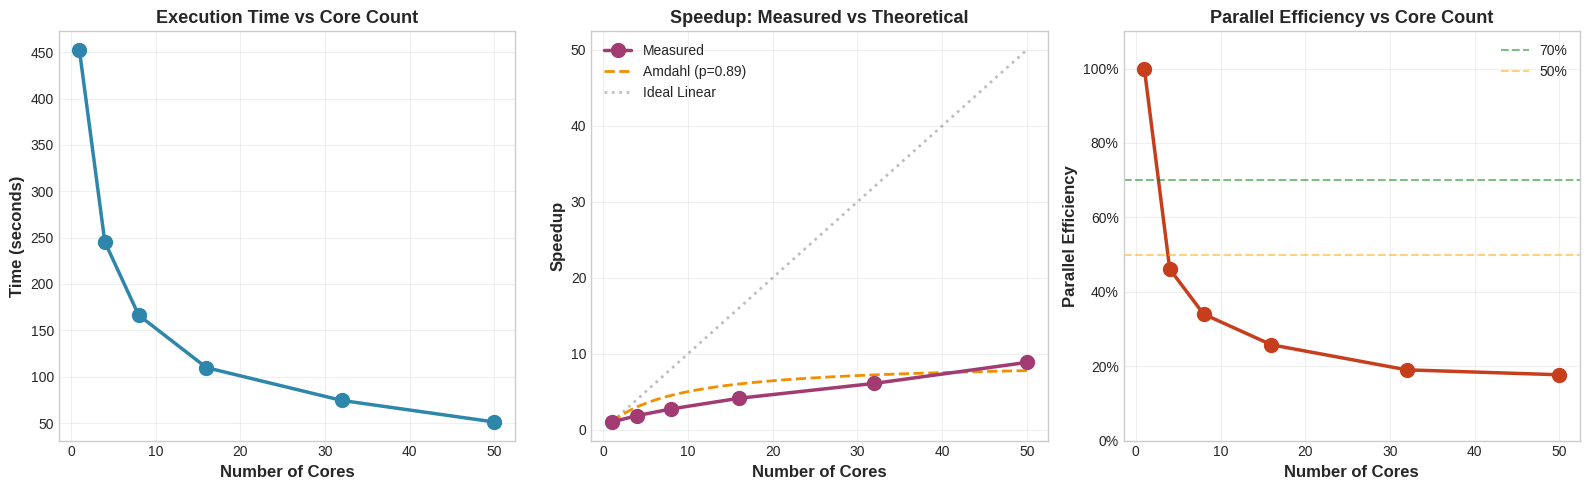

✅ Visualization saved: joblib_rolling_features_performance.png


In [13]:
# ============================================================================
# CELL 12: VISUALIZE JOBLIB PERFORMANCE
# ============================================================================
#
# WHY: Visual comparison of speedup and efficiency
# WHAT: Create 3-panel figure showing time, speedup, and efficiency
#
# ============================================================================

print("\n" + "="*80)
print(" GENERATING PERFORMANCE VISUALIZATIONS ".center(80))
print("="*80)

cores_range = np.arange(1, 51)
amdahl_curve = [amdahl_speedup(p_estimated, n) for n in cores_range]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Execution Time
axes[0].plot(results_df.index, results_df['time'], 'o-',
             linewidth=2.5, markersize=10, color='#2E86AB')
axes[0].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_title('Execution Time vs Core Count', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Panel 2: Speedup
axes[1].plot(results_df.index, results_df['speedup'], 'o-',
             linewidth=2.5, markersize=10, color='#A23B72', label='Measured', zorder=3)
axes[1].plot(cores_range, amdahl_curve, '--',
             linewidth=2, color='#F18F01', label=f'Amdahl (p={p_estimated:.2f})', zorder=2)
axes[1].plot(cores_range, cores_range, ':',
             linewidth=2, color='gray', alpha=0.5, label='Ideal Linear', zorder=1)
axes[1].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Speedup', fontsize=12, fontweight='bold')
axes[1].set_title('Speedup: Measured vs Theoretical', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Panel 3: Efficiency
axes[2].plot(results_df.index, results_df['efficiency'], 'o-',
             linewidth=2.5, markersize=10, color='#C73E1D')
axes[2].axhline(y=0.7, linestyle='--', alpha=0.5, color='green', label='70%')
axes[2].axhline(y=0.5, linestyle='--', alpha=0.5, color='orange', label='50%')
axes[2].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Parallel Efficiency', fontsize=12, fontweight='bold')
axes[2].set_title('Parallel Efficiency vs Core Count', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1.1])
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.savefig('joblib_rolling_features_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: joblib_rolling_features_performance.png")

In [14]:
# ============================================================================
# CELL 13: APPLY FEATURES TO VALIDATION & TEST SETS
# ============================================================================
#
# WHY: Need same features for val/test to make predictions
# HOW: Apply rolling feature function sequentially (one-time operation)
#
# DECISION: Sequential is fine here (only done once, not part of benchmark)
#
# ============================================================================

print("\n" + "="*80)
print(" APPLYING FEATURES TO VALIDATION & TEST SETS ".center(80))
print("="*80)

print("🔄 Validation set...")
start = time.time()
df_val_with_features = compute_features_sequential(df_val)
val_time = time.time() - start
print(f"✅ {df_val_with_features.shape} in {val_time:.1f}s ({val_time/60:.2f} min)")

print("\n🔄 Test set...")
start = time.time()
df_test_with_features = compute_features_sequential(df_test)
test_time = time.time() - start
print(f"✅ {df_test_with_features.shape} in {test_time:.1f}s ({test_time/60:.2f} min)")

print("\n✅ All features generated")


                  APPLYING FEATURES TO VALIDATION & TEST SETS                   
🔄 Validation set...
✅ (742340, 75) in 154.2s (2.57 min)

🔄 Test set...
✅ (341584, 75) in 68.7s (1.14 min)

✅ All features generated


In [15]:
# ============================================================================
# CELL 14: PREPARE DATASETS FOR MODELING
# ============================================================================
#
# WHY: Convert dataframes to X (features) and y (target) format
# WHAT: 
# - Drop NaN rows (from rolling window edges)
# - Separate features from target
# - Keep only numeric features for modeling
#
# ============================================================================

print("\n" + "="*80)
print(" PREPARING MODELING DATASETS ".center(80))
print("="*80)

def prepare_for_model(df_in: pd.DataFrame):
    """Extract features and target from dataframe"""
    # Drop NaNs (from rolling window/lag features at start of each location)
    df_model = df_in.dropna().reset_index(drop=True)
    
    # Define non-feature columns
    target_col = 'Wildfire'
    exclude_cols = [
        target_col, 'datetime',
        'latitude', 'longitude',
        'year', 'month', 'dayofyear'
    ]
    
    # Get numeric feature columns
    numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    # Split X and y
    X = df_model[feature_cols]
    y = df_model[target_col]
    
    return X, y, feature_cols, df_model

X_train, y_train, feature_cols, df_train_final = prepare_for_model(df_train_with_features)
X_val, y_val, _, df_val_final = prepare_for_model(df_val_with_features)
X_test, y_test, _, df_test_final = prepare_for_model(df_test_with_features)

print(f"✅ Datasets prepared")
print(f"\n📊 Feature count: {len(feature_cols)}")
print(f"\nTrain: {X_train.shape} | Fire rate: {y_train.mean():.2%}")
print(f"Val:   {X_val.shape}   | Fire rate: {y_val.mean():.2%}")
print(f"Test:  {X_test.shape}  | Fire rate: {y_test.mean():.2%}")


                          PREPARING MODELING DATASETS                           
✅ Datasets prepared

📊 Feature count: 70

Train: (1315871, 70) | Fire rate: 18.29%
Val:   (420408, 70)   | Fire rate: 25.05%
Test:  (202506, 70)  | Fire rate: 29.16%



                      PARALLEL HYPERPARAMETER OPTIMIZATION                      
✅ Converted to numpy arrays for parallel safety
🔍 Grid search: 12 configurations
⏱️  Estimated time per config: ~30 seconds

🔄 1 core...
✅ 1 cores: 335.2s (5.59 min)

🔄 4 cores...
✅ 4 cores: 99.4s (1.66 min)

🔄 8 cores...
✅ 8 cores: 68.1s (1.13 min)

🔄 16 cores...
✅ 16 cores: 39.5s (0.66 min)

🏆 Best configuration: AUC = 0.6656
  max_depth: 7
  learning_rate: 0.12
  subsample: 0.95

                              TOP 5 CONFIGURATIONS                              

1. AUC: 0.6656
   {'max_depth': 7, 'learning_rate': 0.12, 'subsample': 0.95}

2. AUC: 0.6640
   {'max_depth': 7, 'learning_rate': 0.12, 'subsample': 0.85}

3. AUC: 0.6622
   {'max_depth': 7, 'learning_rate': 0.12, 'subsample': 0.75}

4. AUC: 0.6617
   {'max_depth': 7, 'learning_rate': 0.08, 'subsample': 0.75}

5. AUC: 0.6602
   {'max_depth': 7, 'learning_rate': 0.08, 'subsample': 0.95}

                       HYPERPARAMETER SEARCH PERFORMANCE    

,n_cores,time,speedup,efficiency
0,1,335.2s,1.00x,100.0%
1,4,99.4s,3.37x,84.3%
2,8,68.1s,4.93x,61.6%
3,16,39.5s,8.48x,53.0%



🚀 Speedup at 16 cores: 8.48x


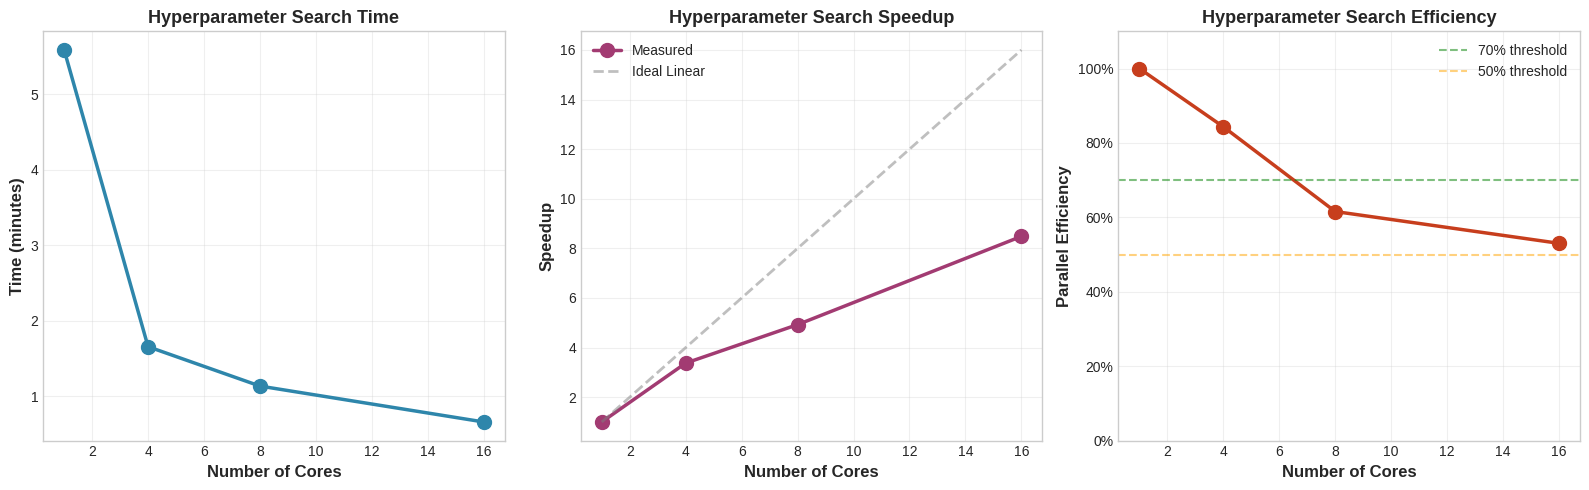


✅ Hyperparameter search complete!
✅ Visualization saved to 'hyperparameter_parallel_performance.png'


In [16]:
# ============================================================================
# CELL 15: PARALLEL HYPERPARAMETER SEARCH (FIXED)
# ============================================================================

print("\n" + "="*80)
print(" PARALLEL HYPERPARAMETER OPTIMIZATION ".center(80))
print("="*80)

from itertools import product
import numpy as np

# Convert DataFrames to numpy arrays ONCE (avoids serialization issues)
X_train_np = np.array(X_train, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)
X_val_np = np.array(X_val, dtype=np.float32)
y_val_np = np.array(y_val, dtype=np.float32)

print(f"✅ Converted to numpy arrays for parallel safety")

# Grid (reduced for speed)
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.08, 0.12],
    'subsample': [0.75, 0.85, 0.95]
}

param_combinations = [
    dict(zip(param_grid.keys(), v))
    for v in product(*param_grid.values())
]

print(f"🔍 Grid search: {len(param_combinations)} configurations")
print(f"⏱️  Estimated time per config: ~30 seconds\n")

def train_and_evaluate(params, X_tr, y_tr, X_va, y_va):
    """Train one XGBoost configuration"""
    import xgboost as xgb
    from sklearn.metrics import roc_auc_score
    
    model_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 100,
        'min_child_weight': 5,
        'colsample_bytree': 0.8,
        'scale_pos_weight': (y_tr == 0).sum() / (y_tr == 1).sum(),
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': 0,
        **params
    }
    
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_tr, y_tr, verbose=False)
    y_pred = model.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, y_pred)
    
    return params, auc

# Benchmark with different core counts
hyperparam_cores = [1, 4, 8, 16]
hyperparam_results = {}

for n_cores in hyperparam_cores:
    print(f"🔄 {n_cores} core{'s' if n_cores > 1 else ''}...")
    start = time.time()
    
    if n_cores == 1:
        results = [train_and_evaluate(p, X_train_np, y_train_np, X_val_np, y_val_np)
                   for p in param_combinations]
    else:
        results = Parallel(n_jobs=n_cores, verbose=0)(  # Changed verbose to 0
            delayed(train_and_evaluate)(p, X_train_np, y_train_np, X_val_np, y_val_np)
            for p in param_combinations
        )
    
    elapsed = time.time() - start
    hyperparam_results[n_cores] = {'time': elapsed, 'results': results}
    print(f"✅ {n_cores} cores: {elapsed:.1f}s ({elapsed/60:.2f} min)\n")

# Find best
best_params, best_auc = max(hyperparam_results[1]['results'], key=lambda x: x[1])

print(f"{'='*80}")
print(f"🏆 Best configuration: AUC = {best_auc:.4f}")
print(f"{'='*80}")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Show all results
print(f"\n{'='*80}")
print(" TOP 5 CONFIGURATIONS ".center(80))
print(f"{'='*80}")
sorted_results = sorted(hyperparam_results[1]['results'], key=lambda x: x[1], reverse=True)
for i, (params, auc) in enumerate(sorted_results[:5], 1):
    print(f"\n{i}. AUC: {auc:.4f}")
    print(f"   {params}")

# Performance analysis
hyperparam_df = pd.DataFrame({
    'n_cores': hyperparam_cores,
    'time': [hyperparam_results[n]['time'] for n in hyperparam_cores]
})
hyperparam_df['speedup'] = hyperparam_df['time'].iloc[0] / hyperparam_df['time']
hyperparam_df['efficiency'] = hyperparam_df['speedup'] / hyperparam_df['n_cores']

print(f"\n{'='*80}")
print(" HYPERPARAMETER SEARCH PERFORMANCE ".center(80))
print(f"{'='*80}")
display(hyperparam_df.style.format({
    'time': '{:.1f}s',
    'speedup': '{:.2f}x',
    'efficiency': '{:.1%}'
}))

hyperparam_speedup_16 = hyperparam_df.loc[hyperparam_df['n_cores']==16, 'speedup'].values[0]
print(f"\n🚀 Speedup at 16 cores: {hyperparam_speedup_16:.2f}x")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Time
axes[0].plot(hyperparam_df['n_cores'], hyperparam_df['time']/60, 
             'o-', linewidth=2.5, markersize=10, color='#2E86AB')
axes[0].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (minutes)', fontsize=12, fontweight='bold')
axes[0].set_title('Hyperparameter Search Time', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Speedup
axes[1].plot(hyperparam_df['n_cores'], hyperparam_df['speedup'], 
             'o-', linewidth=2.5, markersize=10, color='#A23B72', label='Measured')
axes[1].plot(hyperparam_df['n_cores'], hyperparam_df['n_cores'], 
             '--', linewidth=2, color='gray', alpha=0.5, label='Ideal Linear')
axes[1].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Speedup', fontsize=12, fontweight='bold')
axes[1].set_title('Hyperparameter Search Speedup', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Efficiency
axes[2].plot(hyperparam_df['n_cores'], hyperparam_df['efficiency'], 
             'o-', linewidth=2.5, markersize=10, color='#C73E1D')
axes[2].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='70% threshold')
axes[2].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
axes[2].set_xlabel('Number of Cores', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Parallel Efficiency', fontsize=12, fontweight='bold')
axes[2].set_title('Hyperparameter Search Efficiency', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
axes[2].set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('hyperparameter_parallel_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Hyperparameter search complete!")
print(f"✅ Visualization saved to 'hyperparameter_parallel_performance.png'")


In [17]:
# ============================================================================
# DASK XGBOOST: DISTRIBUTED TRAINING WITH DIFFERENT CPU COUNTS
# ============================================================================

from dask.distributed import Client, LocalCluster
import dask.array as da
from xgboost.dask import DaskXGBClassifier

import os
import numpy as np
import pandas as pd
import time

# Avoid oversubscription inside workers
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# Choose CPU counts you want to benchmark on Explorer
CPU_LIST = [1, 4, 8, 16, 28]   # adjust if your node has fewer cores
CHUNK_ROWS = 50_000
RANDOM_STATE = 42


def to_dask_arrays(X, y, chunk_rows=CHUNK_ROWS):
    """
    Convert full pandas X, y into Dask arrays.
    This uses the ENTIRE dataset, just chunked for parallelism.
    """
    X_da = da.from_array(
        X.to_numpy(dtype=np.float32),
        chunks=(chunk_rows, X.shape[1])
    )
    y_da = da.from_array(
        y.to_numpy(dtype=np.int8),
        chunks=(chunk_rows,)
    )
    return X_da, y_da


# Convert train/test to Dask arrays ONCE
Xtr_da, ytr_da = to_dask_arrays(X_train, y_train)
Xte_da, yte_da = to_dask_arrays(X_test, y_test)

results_dask_xgb = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"🚀 Dask XGBoost with {n_cpus} CPU(s)".center(80))
    print("="*80)

    # One worker ~ one CPU core (threads_per_worker = 1)
    cluster = LocalCluster(
        n_workers=n_cpus,
        threads_per_worker=1,
        processes=True,
        # you can tune this if you hit memory errors
        memory_limit="4GB"
    )
    client = Client(cluster)
    print(client)

    try:
        start_time = time.time()

        # Dask-enabled XGBoost model
        dask_model = DaskXGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            max_depth=8,
            learning_rate=0.08,
            n_estimators=300,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
        )

        # Attach Dask client (important!)
        dask_model.client = client

        # Fit on full train set (Dask arrays)
        dask_model.fit(
            Xtr_da,
            ytr_da,
            eval_set=[(Xte_da, yte_da)],
            verbose=False
        )

        fit_time = time.time() - start_time

        # Predict on full test set
        y_pred_da = dask_model.predict(Xte_da)
        y_proba_da = dask_model.predict_proba(Xte_da)[:, 1]

        # Bring results back to NumPy / pandas
        y_pred = np.array(y_pred_da.compute())
        y_proba = np.array(y_proba_da.compute())

        # Metrics (sklearn imports already exist in your notebook)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, zero_division=0)

        print(f"⏱️  Train + Eval time: {fit_time:.2f} s")
        print(f"🎯 Test accuracy:      {acc:.3f}")
        print(f"📈 Test ROC-AUC:       {auc:.3f}")
        print("\nClassification report:")
        print(report)

        results_dask_xgb.append({
            "cpus": n_cpus,
            "time_sec": fit_time,
            "accuracy": acc,
            "auc": auc
        })

    finally:
        client.close()
        cluster.close()

# Summarize core-scaling performance
results_df_dask_xgb = pd.DataFrame(results_dask_xgb)
# Assume first row is 1 CPU baseline
baseline_time = results_df_dask_xgb.loc[results_df_dask_xgb['cpus'].idxmin(), 'time_sec']
results_df_dask_xgb["speedup"] = baseline_time / results_df_dask_xgb["time_sec"]
results_df_dask_xgb["efficiency"] = results_df_dask_xgb["speedup"] / results_df_dask_xgb["cpus"]

print("\n" + "="*80)
print(" DASK XGBOOST PARALLELIZATION RESULTS ".center(80))
print("="*80)
display(results_df_dask_xgb)


                          🚀 Dask XGBoost with 1 CPU(s)                          
<Client: 'tcp://127.0.0.1:38033' processes=1 threads=1, memory=3.73 GiB>


[12:36:21] Task [xgboost.dask-0]:tcp://127.0.0.1:33919 got rank 0


⏱️  Train + Eval time: 83.61 s
🎯 Test accuracy:      0.617
📈 Test ROC-AUC:       0.576

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.54      0.54      0.54    202506
weighted avg       0.62      0.62      0.62    202506


                          🚀 Dask XGBoost with 4 CPU(s)                          
<Client: 'tcp://127.0.0.1:38127' processes=4 threads=4, memory=14.90 GiB>


[12:37:49] Task [xgboost.dask-2]:tcp://127.0.0.1:33299 got rank 2
[12:37:49] Task [xgboost.dask-1]:tcp://127.0.0.1:38787 got rank 1
[12:37:49] Task [xgboost.dask-0]:tcp://127.0.0.1:43429 got rank 0
[12:37:49] Task [xgboost.dask-3]:tcp://127.0.0.1:34659 got rank 3


⏱️  Train + Eval time: 46.75 s
🎯 Test accuracy:      0.623
📈 Test ROC-AUC:       0.579

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73    143450
           1       0.36      0.36      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.55      0.55      0.55    202506
weighted avg       0.62      0.62      0.62    202506


                          🚀 Dask XGBoost with 8 CPU(s)                          
<Client: 'tcp://127.0.0.1:40255' processes=8 threads=8, memory=29.80 GiB>


[12:38:38] Task [xgboost.dask-4]:tcp://127.0.0.1:44563 got rank 4
[12:38:38] Task [xgboost.dask-5]:tcp://127.0.0.1:44771 got rank 5
[12:38:38] Task [xgboost.dask-3]:tcp://127.0.0.1:34881 got rank 3
[12:38:38] Task [xgboost.dask-6]:tcp://127.0.0.1:38943 got rank 6
[12:38:38] Task [xgboost.dask-1]:tcp://127.0.0.1:33149 got rank 1
[12:38:38] Task [xgboost.dask-0]:tcp://127.0.0.1:43905 got rank 0
[12:38:38] Task [xgboost.dask-7]:tcp://127.0.0.1:39753 got rank 7[12:38:38] Task [xgboost.dask-2]:tcp://127.0.0.1:34301 got rank 2

Worker tcp://127.0.0.1:44771 has an empty DMatrix.
Worker tcp://127.0.0.1:34301 has an empty DMatrix.
Worker tcp://127.0.0.1:34881 has an empty DMatrix.
[12:38:40] WARNING: /workspace/src/common/error_msg.cc:56: Empty dataset at worker: 5
[12:38:40] WARNING: /workspace/src/common/error_msg.cc:56: Empty dataset at worker: 3
[12:38:40] WARNING: /workspace/src/common/error_msg.cc:56: Empty dataset at worker: 2


⏱️  Train + Eval time: 42.47 s
🎯 Test accuracy:      0.622
📈 Test ROC-AUC:       0.578

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73    143450
           1       0.36      0.36      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.55      0.55      0.55    202506
weighted avg       0.62      0.62      0.62    202506


                         🚀 Dask XGBoost with 16 CPU(s)                          
<Client: 'tcp://127.0.0.1:38621' processes=16 threads=16, memory=59.60 GiB>


[12:39:25] Task [xgboost.dask-1]:tcp://127.0.0.1:41537 got rank 7
[12:39:25] Task [xgboost.dask-15]:tcp://127.0.0.1:39777 got rank 6
[12:39:25] Task [xgboost.dask-3]:tcp://127.0.0.1:43495 got rank 9
[12:39:25] Task [xgboost.dask-2]:tcp://127.0.0.1:43177 got rank 8
[12:39:25] Task [xgboost.dask-4]:tcp://127.0.0.1:45453 got rank 10
[12:39:25] Task [xgboost.dask-10]:tcp://127.0.0.1:46225 got rank 1
[12:39:25] Task [xgboost.dask-5]:tcp://127.0.0.1:37935 got rank 11
[12:39:25] Task [xgboost.dask-0]:tcp://127.0.0.1:39091 got rank 0
[12:39:25] Task [xgboost.dask-6]:tcp://127.0.0.1:34753 got rank 12
[12:39:25] Task [xgboost.dask-7]:tcp://127.0.0.1:42443 got rank 13
[12:39:25] Task [xgboost.dask-14]:tcp://127.0.0.1:32843 got rank 5
[12:39:25] Task [xgboost.dask-13]:tcp://127.0.0.1:43079 got rank 4
[12:39:25] Task [xgboost.dask-8]:tcp://127.0.0.1:38997 got rank 14
[12:39:25] Task [xgboost.dask-12]:tcp://127.0.0.1:38195 got rank 3
[12:39:25] Task [xgboost.dask-9]:tcp://127.0.0.1:41971 got rank 15

⏱️  Train + Eval time: 59.30 s
🎯 Test accuracy:      0.621
📈 Test ROC-AUC:       0.580

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73    143450
           1       0.36      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.55      0.55      0.55    202506
weighted avg       0.62      0.62      0.62    202506


                         🚀 Dask XGBoost with 28 CPU(s)                          
<Client: 'tcp://127.0.0.1:33581' processes=28 threads=28, memory=104.31 GiB>


[12:40:29] Task [xgboost.dask-18]:tcp://127.0.0.1:41091 got rank 9
[12:40:29] Task [xgboost.dask-20]:tcp://127.0.0.1:39353 got rank 12
[12:40:29] Task [xgboost.dask-21]:tcp://127.0.0.1:35523 got rank 13
[12:40:29] Task [xgboost.dask-23]:tcp://127.0.0.1:44561 got rank 15
[12:40:29] Task [xgboost.dask-17]:tcp://127.0.0.1:35463 got rank 8
[12:40:29] Task [xgboost.dask-19]:tcp://127.0.0.1:42873 got rank 10
[12:40:29] Task [xgboost.dask-15]:tcp://127.0.0.1:40901 got rank 6[12:40:29] Task [xgboost.dask-22]:tcp://127.0.0.1:41177 got rank 14

[12:40:29] Task [xgboost.dask-24]:tcp://127.0.0.1:46353 got rank 16
[12:40:29] Task [xgboost.dask-16]:tcp://127.0.0.1:38151 got rank 7
[12:40:29] Task [xgboost.dask-0]:tcp://127.0.0.1:40757 got rank 0
[12:40:29] Task [xgboost.dask-11]:tcp://127.0.0.1:42525 got rank 2
[12:40:29] Task [xgboost.dask-25]:tcp://127.0.0.1:41433 got rank 17
[12:40:29] Task [xgboost.dask-1]:tcp://127.0.0.1:42379 got rank 11
[12:40:29] Task [xgboost.dask-10]:tcp://127.0.0.1:34323 

⏱️  Train + Eval time: 69.37 s
🎯 Test accuracy:      0.621
📈 Test ROC-AUC:       0.578

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73    143450
           1       0.35      0.36      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.55      0.55      0.55    202506
weighted avg       0.62      0.62      0.62    202506


                      DASK XGBOOST PARALLELIZATION RESULTS                      


,cpus,time_sec,accuracy,auc,speedup,efficiency
0,1,83.613171,0.617468,0.576281,1.000000,1.000000
1,4,46.749768,0.623369,0.579320,1.788526,0.447131
2,8,42.465750,0.622431,0.578445,1.968955,0.246119
3,16,59.299138,0.621261,0.579625,1.410023,0.088126
4,28,69.365386,0.621335,0.577799,1.205402,0.043050


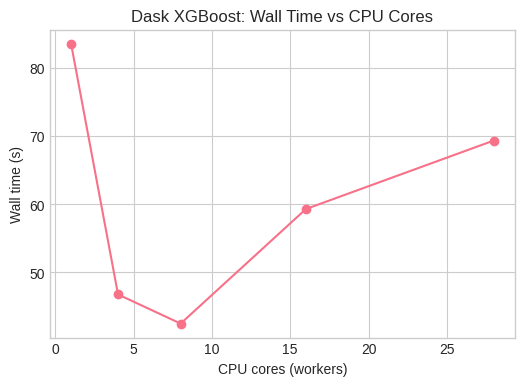

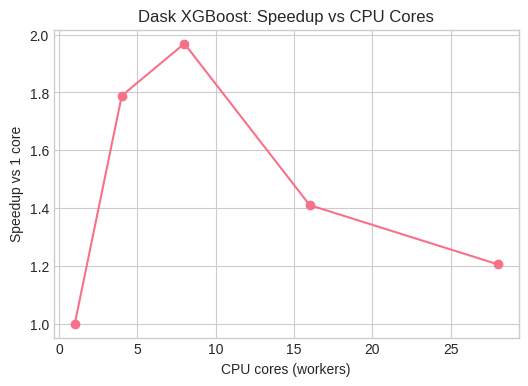

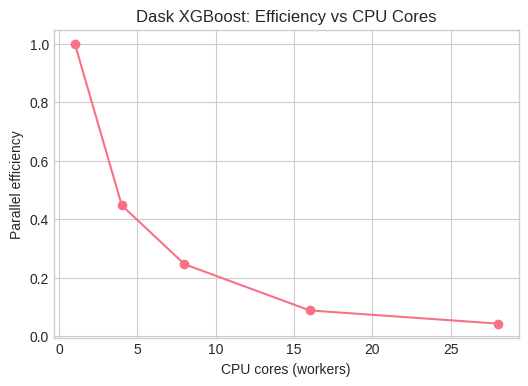

In [18]:
# ============================
# DASK XGBOOST SCALING PLOTS
# ============================

df_dask = results_df_dask_xgb.sort_values("cpus").copy()

# --- Wall time vs CPU cores ---
plt.figure(figsize=(6, 4))
plt.plot(df_dask["cpus"], df_dask["time_sec"], marker="o")
plt.xlabel("CPU cores (workers)")
plt.ylabel("Wall time (s)")
plt.title("Dask XGBoost: Wall Time vs CPU Cores")
plt.grid(True)
plt.show()

# --- Speedup vs CPU cores ---
plt.figure(figsize=(6, 4))
plt.plot(df_dask["cpus"], df_dask["speedup"], marker="o")
plt.xlabel("CPU cores (workers)")
plt.ylabel("Speedup vs 1 core")
plt.title("Dask XGBoost: Speedup vs CPU Cores")
plt.grid(True)
plt.show()

# --- Parallel efficiency vs CPU cores ---
plt.figure(figsize=(6, 4))
plt.plot(df_dask["cpus"], df_dask["efficiency"], marker="o")
plt.xlabel("CPU cores (workers)")
plt.ylabel("Parallel efficiency")
plt.title("Dask XGBoost: Efficiency vs CPU Cores")
plt.grid(True)
plt.show()

In [19]:
# ============================================================================
# XGBOOST + JOBLIB (PROCESS-BASED PARALLELISM) WITH DIFFERENT CPU COUNTS
# ============================================================================

import os
import time
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from joblib import parallel_backend

# Avoid oversubscription inside each process
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

CPU_LIST = [1, 4, 8, 16, 28]   # adjust if your node has fewer cores
RANDOM_STATE = 42

def build_xgb_model():
    """
    Create an XGBClassifier with internal threading disabled (n_jobs=1),
    so that PARALLELISM comes ONLY from Joblib processes (loky backend).
    """
    return XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        max_depth=8,
        learning_rate=0.08,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=1,  # IMPORTANT: no internal threads, we parallelize via Joblib
        random_state=RANDOM_STATE,
    )


results_joblib_xgb = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"⚙️ Joblib (loky) XGBoost with {n_cpus} CPU process(es)".center(80))
    print("="*80)

    # Model used for CV (wrapped by joblib)
    xgb_for_cv = build_xgb_model()

    # --- Cross-validation with Joblib process-based parallelism ---
    start_time = time.time()
    # Each CV fold will run in a separate process (up to n_cpus processes)
    with parallel_backend("loky", n_jobs=n_cpus):
        cv_scores = cross_val_score(
            xgb_for_cv,
            X_train,
            y_train,
            cv=3,
            scoring="roc_auc"
        )
    cv_time = time.time() - start_time

    mean_cv_auc = float(np.mean(cv_scores))
    std_cv_auc = float(np.std(cv_scores))

    print(f"⏱️  3-fold CV wall-clock time: {cv_time:.2f} s")
    print(f"📈 Mean CV ROC-AUC:           {mean_cv_auc:.3f} ± {std_cv_auc:.3f}")

    # --- Train final model on full train set (single process) ---
    # This is to get test metrics comparable across all methods
    xgb_final = build_xgb_model()
    xgb_final.fit(X_train, y_train)

    y_pred = xgb_final.predict(X_test)
    y_proba = xgb_final.predict_proba(X_test)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"🎯 Test accuracy:  {test_acc:.3f}")
    print(f"📊 Test ROC-AUC:   {test_auc:.3f}")
    print("\nClassification report:")
    print(report)

    results_joblib_xgb.append({
        "cpus": n_cpus,
        "cv_time_sec": cv_time,
        "cv_auc_mean": mean_cv_auc,
        "test_accuracy": test_acc,
        "test_auc": test_auc
    })

# ----------------------------------------------------------------------------
# Summarize Joblib scaling: speedup & efficiency (based on CV wall-clock time)
# ----------------------------------------------------------------------------

results_df_joblib_xgb = pd.DataFrame(results_joblib_xgb).sort_values("cpus")

# Take 1-CPU case as baseline
baseline_time = results_df_joblib_xgb.loc[
    results_df_joblib_xgb["cpus"] == results_df_joblib_xgb["cpus"].min(),
    "cv_time_sec"
].iloc[0]

results_df_joblib_xgb["speedup"] = baseline_time / results_df_joblib_xgb["cv_time_sec"]
results_df_joblib_xgb["efficiency"] = (
    results_df_joblib_xgb["speedup"] / results_df_joblib_xgb["cpus"]
)

print("\n" + "="*80)
print(" JOBLIB (PROCESS-BASED) XGBOOST PARALLELIZATION RESULTS ".center(80))
print("="*80)
display(results_df_joblib_xgb)


                ⚙️ Joblib (loky) XGBoost with 1 CPU process(es)                 
⏱️  3-fold CV wall-clock time: 164.05 s
📈 Mean CV ROC-AUC:           0.735 ± 0.034
🎯 Test accuracy:  0.617
📊 Test ROC-AUC:   0.576

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.54      0.54      0.54    202506
weighted avg       0.62      0.62      0.62    202506


                ⚙️ Joblib (loky) XGBoost with 4 CPU process(es)                 
⏱️  3-fold CV wall-clock time: 63.66 s
📈 Mean CV ROC-AUC:           0.735 ± 0.034
🎯 Test accuracy:  0.617
📊 Test ROC-AUC:   0.576

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                        

,cpus,cv_time_sec,cv_auc_mean,test_accuracy,test_auc,speedup,efficiency
0,1,164.050633,0.735121,0.617468,0.576281,1.000000,1.000000
1,4,63.655727,0.735121,0.617468,0.576281,2.577154,0.644289
2,8,63.779415,0.735121,0.617468,0.576281,2.572156,0.321520
3,16,63.451724,0.735121,0.617468,0.576281,2.585440,0.161590
4,28,64.701270,0.735121,0.617468,0.576281,2.535509,0.090554


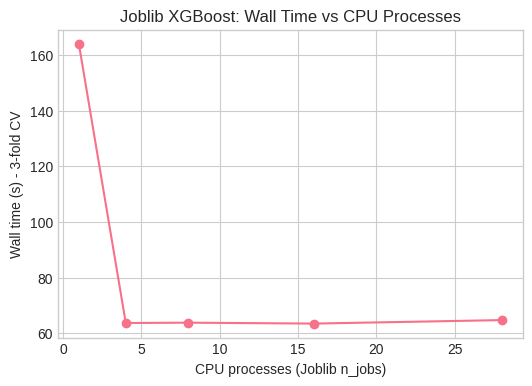

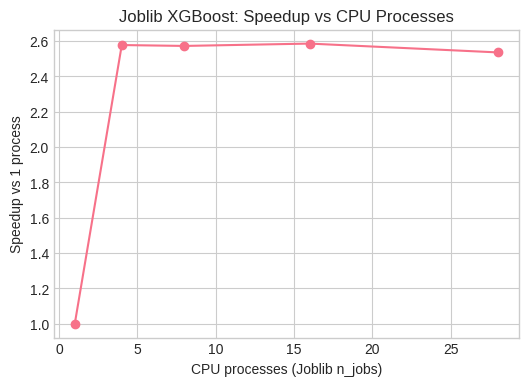

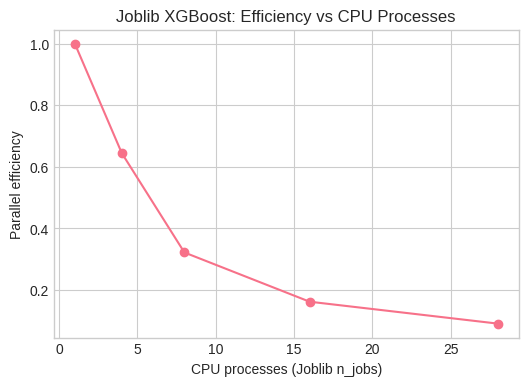

In [20]:
# ================================
# JOBLIB (PROCESS) XGBOOST PLOTS
# ================================

df_joblib = results_df_joblib_xgb.sort_values("cpus").copy()

# --- Wall time vs CPU processes ---
plt.figure(figsize=(6, 4))
plt.plot(df_joblib["cpus"], df_joblib["cv_time_sec"], marker="o")
plt.xlabel("CPU processes (Joblib n_jobs)")
plt.ylabel("Wall time (s) - 3-fold CV")
plt.title("Joblib XGBoost: Wall Time vs CPU Processes")
plt.grid(True)
plt.show()

# --- Speedup vs CPU processes ---
plt.figure(figsize=(6, 4))
plt.plot(df_joblib["cpus"], df_joblib["speedup"], marker="o")
plt.xlabel("CPU processes (Joblib n_jobs)")
plt.ylabel("Speedup vs 1 process")
plt.title("Joblib XGBoost: Speedup vs CPU Processes")
plt.grid(True)
plt.show()

# --- Parallel efficiency vs CPU processes ---
plt.figure(figsize=(6, 4))
plt.plot(df_joblib["cpus"], df_joblib["efficiency"], marker="o")
plt.xlabel("CPU processes (Joblib n_jobs)")
plt.ylabel("Parallel efficiency")
plt.title("Joblib XGBoost: Efficiency vs CPU Processes")
plt.grid(True)
plt.show()

In [21]:
# ============================================================================
# XGBOOST + JOBLIB *BUILT-IN* PARALLELISM WITH DIFFERENT CPU COUNTS
#    -> Uses cross_val_score(..., n_jobs=CPU) (Joblib under the hood)
# ============================================================================

import os
import time
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Avoid oversubscription inside each process/thread
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

CPU_LIST = [1, 4, 8, 16, 28]  # adjust if your node has fewer cores
RANDOM_STATE = 42


def build_xgb_model():
    """
    XGBoost model with internal threads disabled (n_jobs=1).
    Parallelism comes from Joblib via cross_val_score(n_jobs=...).
    """
    return XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        max_depth=8,
        learning_rate=0.08,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=1,   # IMPORTANT: avoid nested parallelism
        random_state=RANDOM_STATE,
    )


results_joblib_builtin_xgb = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"🧵 Joblib BUILT-IN CV parallelism (n_jobs={n_cpus}) for XGBoost".center(80))
    print("="*80)

    # --- 3-fold CV with Joblib parallelism via n_jobs ---
    start_time = time.time()
    cv_scores = cross_val_score(
        estimator=build_xgb_model(),
        X=X_train,
        y=y_train,
        cv=3,
        scoring="roc_auc",
        n_jobs=n_cpus  # Joblib will use up to n_cpus workers
    )
    cv_time = time.time() - start_time

    mean_cv_auc = float(np.mean(cv_scores))
    std_cv_auc = float(np.std(cv_scores))

    print(f"⏱️  3-fold CV wall-clock time: {cv_time:.2f} s")
    print(f"📈 Mean CV ROC-AUC:           {mean_cv_auc:.3f} ± {std_cv_auc:.3f}")

    # --- Train final model on full train set (single-threaded) for test metrics ---
    xgb_final = build_xgb_model()
    xgb_final.fit(X_train, y_train)

    y_pred = xgb_final.predict(X_test)
    y_proba = xgb_final.predict_proba(X_test)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"🎯 Test accuracy:  {test_acc:.3f}")
    print(f"📊 Test ROC-AUC:   {test_auc:.3f}")
    print("\nClassification report:")
    print(report)

    results_joblib_builtin_xgb.append({
        "cpus": n_cpus,
        "cv_time_sec": cv_time,
        "cv_auc_mean": mean_cv_auc,
        "test_accuracy": test_acc,
        "test_auc": test_auc
    })

# ----------------------------------------------------------------------------
# Summarize scaling: wall time, speedup, efficiency
# ----------------------------------------------------------------------------

results_df_joblib_builtin_xgb = (
    pd.DataFrame(results_joblib_builtin_xgb)
      .sort_values("cpus")
      .reset_index(drop=True)
)

# 1-CPU case as baseline
baseline_time = results_df_joblib_builtin_xgb.loc[
    results_df_joblib_builtin_xgb["cpus"] == results_df_joblib_builtin_xgb["cpus"].min(),
    "cv_time_sec"
].iloc[0]

results_df_joblib_builtin_xgb["speedup"] = (
    baseline_time / results_df_joblib_builtin_xgb["cv_time_sec"]
)
results_df_joblib_builtin_xgb["efficiency"] = (
    results_df_joblib_builtin_xgb["speedup"] / results_df_joblib_builtin_xgb["cpus"]
)

print("\n" + "="*80)
print(" JOBLIB BUILT-IN PARALLELISM (XGBOOST) RESULTS ".center(80))
print("="*80)
display(results_df_joblib_builtin_xgb)


            🧵 Joblib BUILT-IN CV parallelism (n_jobs=1) for XGBoost             
⏱️  3-fold CV wall-clock time: 163.54 s
📈 Mean CV ROC-AUC:           0.735 ± 0.034
🎯 Test accuracy:  0.617
📊 Test ROC-AUC:   0.576

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.54      0.54      0.54    202506
weighted avg       0.62      0.62      0.62    202506


            🧵 Joblib BUILT-IN CV parallelism (n_jobs=4) for XGBoost             
⏱️  3-fold CV wall-clock time: 62.79 s
📈 Mean CV ROC-AUC:           0.735 ± 0.034
🎯 Test accuracy:  0.617
📊 Test ROC-AUC:   0.576

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                        

,cpus,cv_time_sec,cv_auc_mean,test_accuracy,test_auc,speedup,efficiency
0,1,163.541760,0.735121,0.617468,0.576281,1.000000,1.000000
1,4,62.786533,0.735121,0.617468,0.576281,2.604727,0.651182
2,8,63.753841,0.735121,0.617468,0.576281,2.565206,0.320651
3,16,64.566443,0.735121,0.617468,0.576281,2.532922,0.158308
4,28,64.213273,0.735121,0.617468,0.576281,2.546853,0.090959


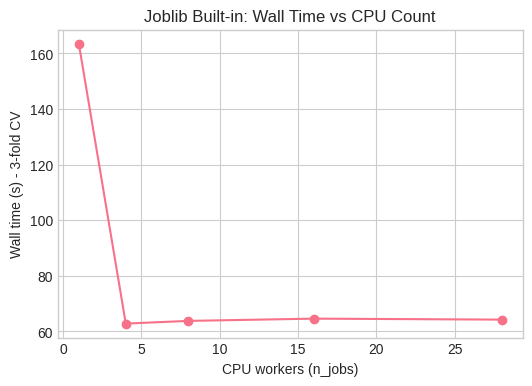

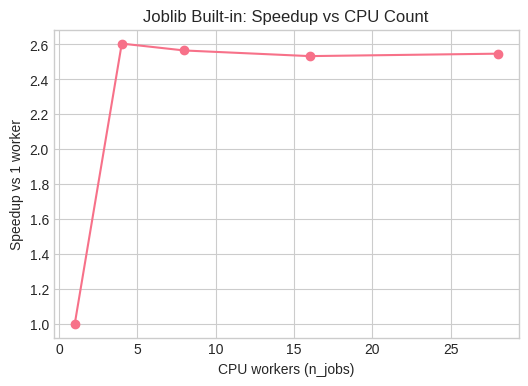

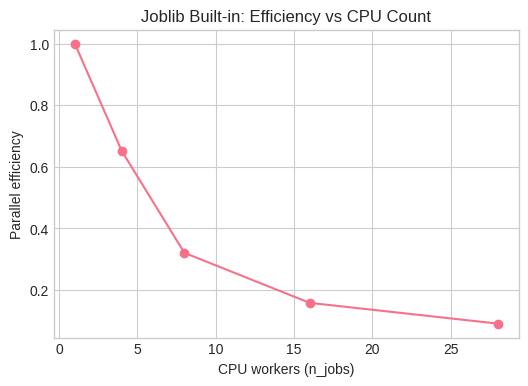

In [22]:
df = results_df_joblib_builtin_xgb

# Wall time
plt.figure(figsize=(6,4))
plt.plot(df["cpus"], df["cv_time_sec"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Wall time (s) - 3-fold CV")
plt.title("Joblib Built-in: Wall Time vs CPU Count")
plt.grid(True)
plt.show()

# Speedup
plt.figure(figsize=(6,4))
plt.plot(df["cpus"], df["speedup"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Speedup vs 1 worker")
plt.title("Joblib Built-in: Speedup vs CPU Count")
plt.grid(True)
plt.show()

# Efficiency
plt.figure(figsize=(6,4))
plt.plot(df["cpus"], df["efficiency"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Parallel efficiency")
plt.title("Joblib Built-in: Efficiency vs CPU Count")
plt.grid(True)
plt.show()

In [23]:
# ============================================================
# XGBOOST BUILT-IN THREAD PARALLELISM (n_jobs = CPU_LIST)
# ============================================================

import time
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

CPU_LIST = [1, 4, 8, 16, 28]
RANDOM_STATE = 42

results_xgb_thread = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"🧵 XGBoost built-in threads with n_jobs={n_cpus}".center(80))
    print("="*80)

    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        max_depth=8,
        learning_rate=0.08,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=n_cpus,   # <--- HERE we vary with CPU_LIST
        random_state=RANDOM_STATE,
    )

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"⏱️  Train + predict time: {train_time:.2f} s")
    print(f"🎯 Test accuracy:         {acc:.3f}")
    print(f"📈 Test ROC-AUC:          {auc:.3f}")
    print("Classification report:")
    print(report)

    results_xgb_thread.append({
        "cpus": n_cpus,
        "time_sec": train_time,
        "accuracy": acc,
        "auc": auc
    })

results_df_xgb_thread = pd.DataFrame(results_xgb_thread).sort_values("cpus")
baseline_time = results_df_xgb_thread.loc[
    results_df_xgb_thread["cpus"] == results_df_xgb_thread["cpus"].min(),
    "time_sec"
].iloc[0]
results_df_xgb_thread["speedup"] = baseline_time / results_df_xgb_thread["time_sec"]
results_df_xgb_thread["efficiency"] = (
    results_df_xgb_thread["speedup"] / results_df_xgb_thread["cpus"]
)

display(results_df_xgb_thread)


                    🧵 XGBoost built-in threads with n_jobs=1                    
⏱️  Train + predict time: 71.63 s
🎯 Test accuracy:         0.617
📈 Test ROC-AUC:          0.576
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.54      0.54      0.54    202506
weighted avg       0.62      0.62      0.62    202506


                    🧵 XGBoost built-in threads with n_jobs=4                    
⏱️  Train + predict time: 71.95 s
🎯 Test accuracy:         0.617
📈 Test ROC-AUC:          0.576
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73    143450
           1       0.35      0.37      0.36     59056

    accuracy                           0.62    202506
   macro avg       0.54      0.54      0.54    202506

,cpus,time_sec,accuracy,auc,speedup,efficiency
0,1,71.627965,0.617468,0.576281,1.000000,1.000000
1,4,71.949819,0.617468,0.576281,0.995527,0.248882
2,8,72.678937,0.617468,0.576281,0.985540,0.123192
3,16,71.917113,0.617468,0.576281,0.995979,0.062249
4,28,71.907168,0.617468,0.576281,0.996117,0.035576


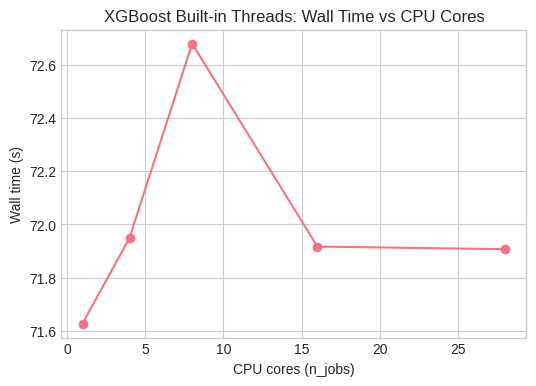

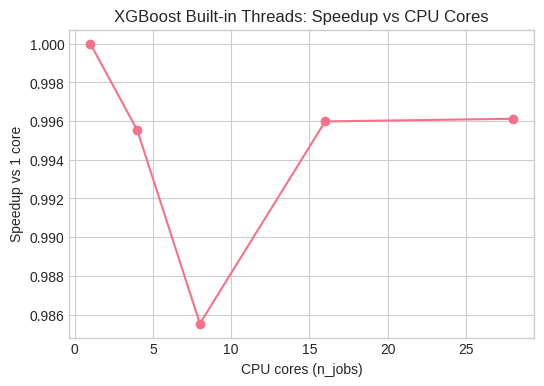

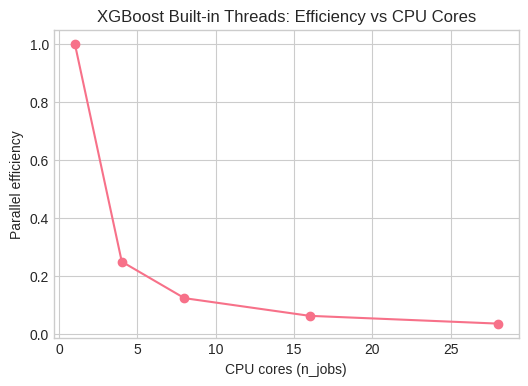

In [24]:
# ==============================================
# XGBoost built-in threads: SCALING PLOTS
# ==============================================

df_thr = results_df_xgb_thread.sort_values("cpus").copy()

# 1) Wall time vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["time_sec"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Wall time (s)")
plt.title("XGBoost Built-in Threads: Wall Time vs CPU Cores")
plt.grid(True)
plt.show()

# 2) Speedup vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["speedup"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Speedup vs 1 core")
plt.title("XGBoost Built-in Threads: Speedup vs CPU Cores")
plt.grid(True)
plt.show()

# 3) Parallel efficiency vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["efficiency"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Parallel efficiency")
plt.title("XGBoost Built-in Threads: Efficiency vs CPU Cores")
plt.grid(True)
plt.show()

In [25]:
import pandas as pd

def pick_best(df, time_col, label):
    """
    df: DataFrame for one method (must have columns: 'cpus', time_col, 'speedup', 'efficiency')
    time_col: name of the wall-time column (e.g., 'time_sec' or 'cv_time_sec')
    label: name of the method (string)
    """
    row = df.sort_values(time_col).iloc[0]
    return {
        "method": label,
        "best_cpus": int(row["cpus"]),
        "best_wall_time": float(row[time_col]),
        "best_speedup": float(row["speedup"]),
        "best_efficiency": float(row["efficiency"]),
    }

In [26]:
best_rows_xgb = []

best_rows_xgb.append(
    pick_best(results_df_xgb_thread, time_col="time_sec",
              label="XGB – built-in threads (n_jobs)")
)

best_rows_xgb.append(
    pick_best(results_df_joblib_xgb, time_col="cv_time_sec",
              label="XGB – Joblib process-based (loky CV)")
)

best_rows_xgb.append(
    pick_best(results_df_joblib_builtin_xgb, time_col="cv_time_sec",
              label="XGB – Joblib built-in CV (n_jobs)")
)

best_rows_xgb.append(
    pick_best(results_df_dask_xgb, time_col="time_sec",
              label="XGB – Dask distributed")
)

summary_best_xgb = pd.DataFrame(best_rows_xgb)
summary_best_xgb

,method,best_cpus,best_wall_time,best_speedup,best_efficiency
0,XGB – built-in threads (n_jobs),1,71.627965,1.000000,1.000000
1,XGB – Joblib process-based (loky CV),16,63.451724,2.585440,0.161590
2,XGB – Joblib built-in CV (n_jobs),4,62.786533,2.604727,0.651182
3,XGB – Dask distributed,8,42.465750,1.968955,0.246119


In [27]:
# ============================================================================
# DASK-BACKED SKLEARN RANDOM FOREST WITH DIFFERENT CPU COUNTS
#   (no dask-ml required)
# ============================================================================

import os
import time
import numpy as np
import pandas as pd

from dask.distributed import Client, LocalCluster
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Avoid BLAS/OpenMP oversubscription inside workers
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

CPU_LIST = [1, 4, 8, 16, 28]   # adjust to your node
RANDOM_STATE = 42

results_dask_rf = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"🌲 Dask-backed RandomForest with {n_cpus} CPU worker(s)".center(80))
    print("="*80)

    # One worker ~ one CPU core (threads_per_worker = 1)
    cluster = LocalCluster(
        n_workers=n_cpus,
        threads_per_worker=1,
        processes=True,
        memory_limit="4GB",   # tune if needed
    )
    client = Client(cluster)
    print(client)

    try:
        # RandomForest uses joblib internally; we redirect joblib to Dask
        rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            max_features="sqrt",
            min_samples_split=2,
            min_samples_leaf=1,
            bootstrap=True,
            n_jobs=-1,            # "all available" -> mapped onto Dask workers
            random_state=RANDOM_STATE,
        )

        start_time = time.time()

        # All RF parallel work (tree building) goes through Dask
        with joblib.parallel_backend("dask"):
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            y_proba = rf.predict_proba(X_test)[:, 1]

        wall_time = time.time() - start_time

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, zero_division=0)

        print(f"⏱️  Train + Predict wall time: {wall_time:.2f} s")
        print(f"🎯 Test accuracy:              {acc:.3f}")
        print(f"📈 Test ROC-AUC:               {auc:.3f}")
        print("\nClassification report:")
        print(report)

        results_dask_rf.append({
            "cpus": n_cpus,
            "time_sec": wall_time,
            "accuracy": acc,
            "auc": auc
        })

    finally:
        client.close()
        cluster.close()

# ----------------------------------------------------------------------------
# Summarize scaling: speedup & efficiency (vs 1 CPU worker)
# ----------------------------------------------------------------------------

results_df_dask_rf = (
    pd.DataFrame(results_dask_rf)
      .sort_values("cpus")
      .reset_index(drop=True)
)

baseline_time = results_df_dask_rf.loc[
    results_df_dask_rf["cpus"] == results_df_dask_rf["cpus"].min(),
    "time_sec"
].iloc[0]

results_df_dask_rf["speedup"] = baseline_time / results_df_dask_rf["time_sec"]
results_df_dask_rf["efficiency"] = (
    results_df_dask_rf["speedup"] / results_df_dask_rf["cpus"]
)

print("\n" + "="*80)
print(" DASK-BACKED RANDOM FOREST PARALLELIZATION RESULTS ".center(80))
print("="*80)
display(results_df_dask_rf)



                🌲 Dask-backed RandomForest with 1 CPU worker(s)                 
<Client: 'tcp://127.0.0.1:38685' processes=1 threads=1, memory=3.73 GiB>
⏱️  Train + Predict wall time: 3540.52 s
🎯 Test accuracy:              0.664
📈 Test ROC-AUC:               0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.66    202506
   macro avg       0.53      0.52      0.51    202506
weighted avg       0.61      0.66      0.62    202506


                🌲 Dask-backed RandomForest with 4 CPU worker(s)                 
<Client: 'tcp://127.0.0.1:33975' processes=4 threads=4, memory=14.90 GiB>
⏱️  Train + Predict wall time: 972.22 s
🎯 Test accuracy:              0.664
📈 Test ROC-AUC:               0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86 

,cpus,time_sec,accuracy,auc,speedup,efficiency
0,1,3540.520936,0.664059,0.553973,1.000000,1.000000
1,4,972.219748,0.664059,0.553973,3.641688,0.910422
2,8,503.401038,0.664059,0.553973,7.033201,0.879150
3,16,298.356080,0.664059,0.553973,11.866763,0.741673
4,28,220.712180,0.664059,0.553973,16.041348,0.572905


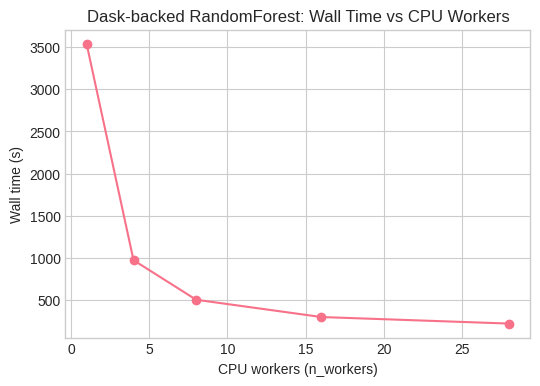

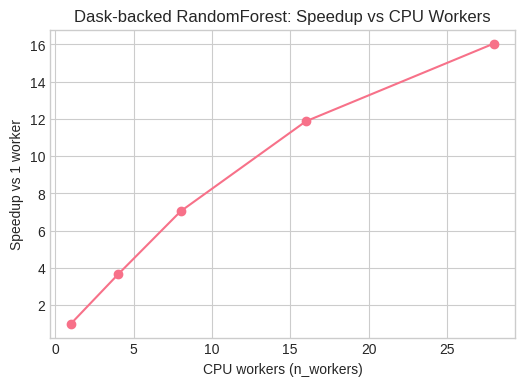

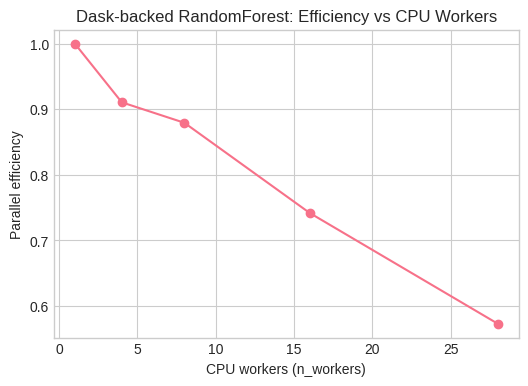

In [28]:
df_rf = results_df_dask_rf

# Wall time
plt.figure(figsize=(6, 4))
plt.plot(df_rf["cpus"], df_rf["time_sec"], marker="o")
plt.xlabel("CPU workers (n_workers)")
plt.ylabel("Wall time (s)")
plt.title("Dask-backed RandomForest: Wall Time vs CPU Workers")
plt.grid(True)
plt.show()

# Speedup
plt.figure(figsize=(6, 4))
plt.plot(df_rf["cpus"], df_rf["speedup"], marker="o")
plt.xlabel("CPU workers (n_workers)")
plt.ylabel("Speedup vs 1 worker")
plt.title("Dask-backed RandomForest: Speedup vs CPU Workers")
plt.grid(True)
plt.show()

# Efficiency
plt.figure(figsize=(6, 4))
plt.plot(df_rf["cpus"], df_rf["efficiency"], marker="o")
plt.xlabel("CPU workers (n_workers)")
plt.ylabel("Parallel efficiency")
plt.title("Dask-backed RandomForest: Efficiency vs CPU Workers")
plt.grid(True)
plt.show()

In [29]:
# ============================================================================
# RANDOM FOREST + JOBLIB (PROCESS-BASED PARALLELISM) WITH DIFFERENT CPU COUNTS
#   - Parallelism via cross_val_score(..., n_jobs=CPU_LIST) using loky backend
#   - RandomForestClassifier itself runs single-process (n_jobs=1)
# ============================================================================

import os
import time
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from joblib import parallel_backend

# Avoid oversubscription inside processes
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

CPU_LIST = [1, 4, 8, 16, 28]   # adjust to your node
RANDOM_STATE = 42


def build_rf_model():
    """
    RandomForest with internal parallelism turned off (n_jobs=1).
    All parallelism comes from Joblib at the CV level (loky).
    """
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        n_jobs=1,  # IMPORTANT: no internal threads, we parallelize via Joblib
        random_state=RANDOM_STATE,
    )


results_joblib_rf = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"⚙️ Joblib (loky) RandomForest with {n_cpus} CPU process(es)".center(80))
    print("="*80)

    # --- 3-fold CV with Joblib process-based parallelism ---
    start_time = time.time()
    with parallel_backend("loky", n_jobs=n_cpus):
        cv_scores = cross_val_score(
            estimator=build_rf_model(),
            X=X_train,
            y=y_train,
            cv=3,
            scoring="roc_auc",
        )
    cv_time = time.time() - start_time

    mean_cv_auc = float(np.mean(cv_scores))
    std_cv_auc = float(np.std(cv_scores))

    print(f"⏱️  3-fold CV wall-clock time: {cv_time:.2f} s")
    print(f"📈 Mean CV ROC-AUC:           {mean_cv_auc:.3f} ± {std_cv_auc:.3f}")

    # --- Train final RF on full train set (single-process) for test metrics ---
    rf_final = build_rf_model()
    rf_final.fit(X_train, y_train)

    y_pred = rf_final.predict(X_test)
    y_proba = rf_final.predict_proba(X_test)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"🎯 Test accuracy:  {test_acc:.3f}")
    print(f"📊 Test ROC-AUC:   {test_auc:.3f}")
    print("\nClassification report:")
    print(report)

    results_joblib_rf.append({
        "cpus": n_cpus,
        "cv_time_sec": cv_time,
        "cv_auc_mean": mean_cv_auc,
        "test_accuracy": test_acc,
        "test_auc": test_auc
    })

# ----------------------------------------------------------------------------
# Summarize scaling: speedup & efficiency (based on CV wall-clock time)
# ----------------------------------------------------------------------------

results_df_joblib_rf = (
    pd.DataFrame(results_joblib_rf)
      .sort_values("cpus")
      .reset_index(drop=True)
)

# 1-CPU case as baseline
baseline_time = results_df_joblib_rf.loc[
    results_df_joblib_rf["cpus"] == results_df_joblib_rf["cpus"].min(),
    "cv_time_sec"
].iloc[0]

results_df_joblib_rf["speedup"] = baseline_time / results_df_joblib_rf["cv_time_sec"]
results_df_joblib_rf["efficiency"] = (
    results_df_joblib_rf["speedup"] / results_df_joblib_rf["cpus"]
)

print("\n" + "="*80)
print(" JOBLIB (PROCESS-BASED) RANDOM FOREST RESULTS ".center(80))
print("="*80)
display(results_df_joblib_rf)


              ⚙️ Joblib (loky) RandomForest with 1 CPU process(es)              
⏱️  3-fold CV wall-clock time: 6702.50 s
📈 Mean CV ROC-AUC:           0.688 ± 0.033
🎯 Test accuracy:  0.664
📊 Test ROC-AUC:   0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.66    202506
   macro avg       0.53      0.52      0.51    202506
weighted avg       0.61      0.66      0.62    202506


              ⚙️ Joblib (loky) RandomForest with 4 CPU process(es)              
⏱️  3-fold CV wall-clock time: 2435.64 s
📈 Mean CV ROC-AUC:           0.688 ± 0.033
🎯 Test accuracy:  0.664
📊 Test ROC-AUC:   0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                     

,cpus,cv_time_sec,cv_auc_mean,test_accuracy,test_auc,speedup,efficiency
0,1,6702.498189,0.687873,0.664059,0.553973,1.000000,1.000000
1,4,2435.636805,0.687873,0.664059,0.553973,2.751846,0.687962
2,8,2411.772300,0.687873,0.664059,0.553973,2.779076,0.347384
3,16,2415.944720,0.687873,0.664059,0.553973,2.774276,0.173392
4,28,2412.743295,0.687873,0.664059,0.553973,2.777957,0.099213


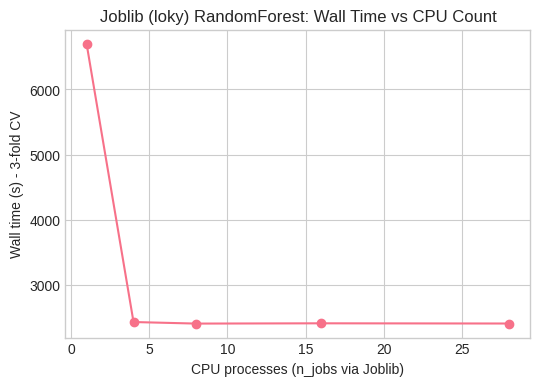

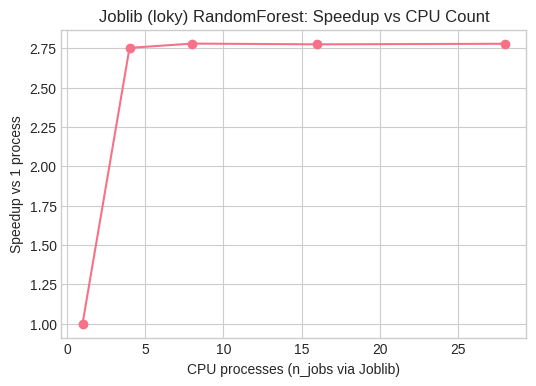

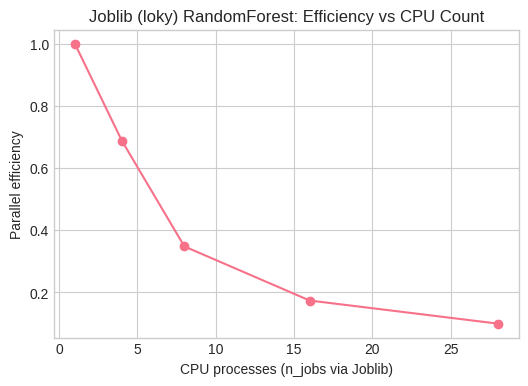

In [30]:
df_rf_joblib = results_df_joblib_rf

# 1) Wall time vs CPU processes
plt.figure(figsize=(6, 4))
plt.plot(df_rf_joblib["cpus"], df_rf_joblib["cv_time_sec"], marker="o")
plt.xlabel("CPU processes (n_jobs via Joblib)")
plt.ylabel("Wall time (s) - 3-fold CV")
plt.title("Joblib (loky) RandomForest: Wall Time vs CPU Count")
plt.grid(True)
plt.show()

# 2) Speedup vs CPU processes
plt.figure(figsize=(6, 4))
plt.plot(df_rf_joblib["cpus"], df_rf_joblib["speedup"], marker="o")
plt.xlabel("CPU processes (n_jobs via Joblib)")
plt.ylabel("Speedup vs 1 process")
plt.title("Joblib (loky) RandomForest: Speedup vs CPU Count")
plt.grid(True)
plt.show()

# 3) Parallel efficiency vs CPU processes
plt.figure(figsize=(6, 4))
plt.plot(df_rf_joblib["cpus"], df_rf_joblib["efficiency"], marker="o")
plt.xlabel("CPU processes (n_jobs via Joblib)")
plt.ylabel("Parallel efficiency")
plt.title("Joblib (loky) RandomForest: Efficiency vs CPU Count")
plt.grid(True)
plt.show()

In [31]:
# ============================================================================
# RANDOM FOREST + JOBLIB *BUILT-IN* PARALLELISM WITH DIFFERENT CPU COUNTS
#   -> Uses cross_val_score(..., n_jobs=CPU) (Joblib under the hood)
# ============================================================================

import os
import time
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Avoid oversubscription inside each worker
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

CPU_LIST = [1, 4, 8, 16, 28]   # adjust if your node has fewer cores
RANDOM_STATE = 42

def build_rf_model():
    """
    RandomForest with internal parallelism disabled (n_jobs=1).
    Parallelism comes from Joblib via cross_val_score(n_jobs=...).
    """
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        n_jobs=1,          # IMPORTANT: no internal RF threads
        random_state=RANDOM_STATE,
    )


results_joblib_builtin_rf = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"Joblib BUILT-IN CV parallelism (n_jobs={n_cpus}) for RandomForest".center(80))
    print("="*80)

    # --- 3-fold CV with Joblib parallelism via n_jobs ---
    start_time = time.time()
    cv_scores = cross_val_score(
        estimator=build_rf_model(),
        X=X_train,
        y=y_train,
        cv=3,
        scoring="roc_auc",
        n_jobs=n_cpus   # Joblib will use up to n_cpus workers
    )
    cv_time = time.time() - start_time

    mean_cv_auc = float(np.mean(cv_scores))
    std_cv_auc  = float(np.std(cv_scores))

    print(f" 3-fold CV wall-clock time: {cv_time:.2f} s")
    print(f" Mean CV ROC-AUC:           {mean_cv_auc:.3f} ± {std_cv_auc:.3f}")

    # --- Train final RF on full train set (single-threaded) for test metrics ---
    rf_final = build_rf_model()
    rf_final.fit(X_train, y_train)

    y_pred  = rf_final.predict(X_test)
    y_proba = rf_final.predict_proba(X_test)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba)
    report   = classification_report(y_test, y_pred, zero_division=0)

    print(f"🎯 Test accuracy:  {test_acc:.3f}")
    print(f"📊 Test ROC-AUC:   {test_auc:.3f}")
    print("\nClassification report:")
    print(report)

    results_joblib_builtin_rf.append({
        "cpus": n_cpus,
        "cv_time_sec": cv_time,
        "cv_auc_mean": mean_cv_auc,
        "test_accuracy": test_acc,
        "test_auc": test_auc
    })


# ----------------------------------------------------------------------------
# Summarize scaling: wall time, speedup, efficiency
# ----------------------------------------------------------------------------

results_df_joblib_builtin_rf = (
    pd.DataFrame(results_joblib_builtin_rf)
      .sort_values("cpus")
      .reset_index(drop=True)
)

# 1-CPU case as baseline
baseline_time = results_df_joblib_builtin_rf.loc[
    results_df_joblib_builtin_rf["cpus"] == results_df_joblib_builtin_rf["cpus"].min(),
    "cv_time_sec"
].iloc[0]

results_df_joblib_builtin_rf["speedup"] = (
    baseline_time / results_df_joblib_builtin_rf["cv_time_sec"]
)
results_df_joblib_builtin_rf["efficiency"] = (
    results_df_joblib_builtin_rf["speedup"] / results_df_joblib_builtin_rf["cpus"]
)

print("\n" + "="*80)
print(" JOBLIB BUILT-IN PARALLELISM (RANDOM FOREST) RESULTS ".center(80))
print("="*80)
display(results_df_joblib_builtin_rf)


           Joblib BUILT-IN CV parallelism (n_jobs=1) for RandomForest           
 3-fold CV wall-clock time: 6689.59 s
 Mean CV ROC-AUC:           0.688 ± 0.033
🎯 Test accuracy:  0.664
📊 Test ROC-AUC:   0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.66    202506
   macro avg       0.53      0.52      0.51    202506
weighted avg       0.61      0.66      0.62    202506


           Joblib BUILT-IN CV parallelism (n_jobs=4) for RandomForest           
 3-fold CV wall-clock time: 2409.57 s
 Mean CV ROC-AUC:           0.688 ± 0.033
🎯 Test accuracy:  0.664
📊 Test ROC-AUC:   0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.

,cpus,cv_time_sec,cv_auc_mean,test_accuracy,test_auc,speedup,efficiency
0,1,6689.589607,0.687873,0.664059,0.553973,1.000000,1.000000
1,4,2409.567673,0.687873,0.664059,0.553973,2.776261,0.694065
2,8,2402.232327,0.687873,0.664059,0.553973,2.784739,0.348092
3,16,2413.942523,0.687873,0.664059,0.553973,2.771230,0.173202
4,28,2395.730965,0.687873,0.664059,0.553973,2.792296,0.099725


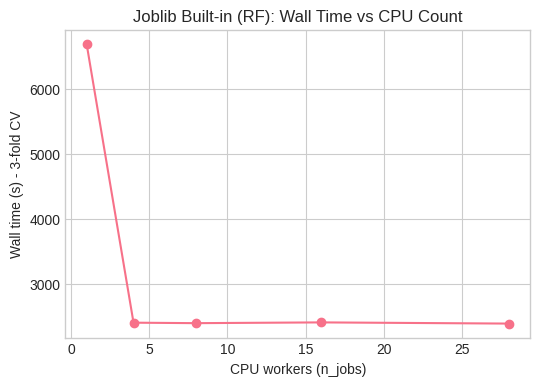

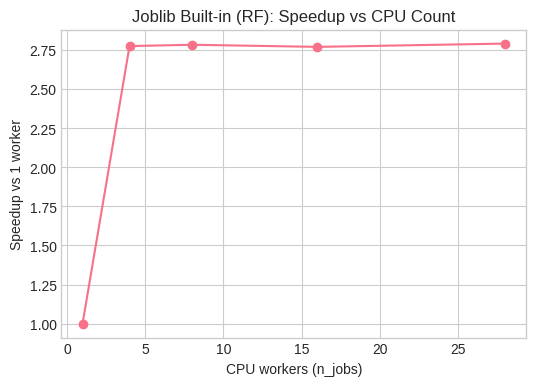

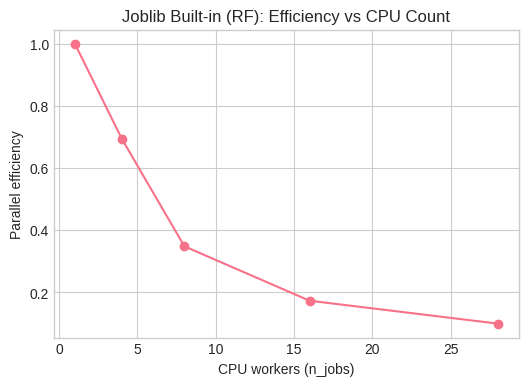

In [32]:
df = results_df_joblib_builtin_rf

# 1) Wall time vs CPU workers
plt.figure(figsize=(6, 4))
plt.plot(df["cpus"], df["cv_time_sec"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Wall time (s) - 3-fold CV")
plt.title("Joblib Built-in (RF): Wall Time vs CPU Count")
plt.grid(True)
plt.show()

# 2) Speedup vs CPU workers
plt.figure(figsize=(6, 4))
plt.plot(df["cpus"], df["speedup"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Speedup vs 1 worker")
plt.title("Joblib Built-in (RF): Speedup vs CPU Count")
plt.grid(True)
plt.show()

# 3) Parallel efficiency vs CPU workers
plt.figure(figsize=(6, 4))
plt.plot(df["cpus"], df["efficiency"], marker="o")
plt.xlabel("CPU workers (n_jobs)")
plt.ylabel("Parallel efficiency")
plt.title("Joblib Built-in (RF): Efficiency vs CPU Count")
plt.grid(True)
plt.show()

In [33]:
# ============================================================================
# RANDOM FOREST + BUILT-IN THREAD-BASED PARALLELISM (n_jobs = CPU_LIST)
#   Single-process, multi-threaded via n_jobs
# ============================================================================

import time
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

CPU_LIST = [1, 4, 8, 16, 28]   # adjust to your node
RANDOM_STATE = 42

results_rf_thread = []

for n_cpus in CPU_LIST:
    print("\n" + "="*80)
    print(f"🧵 RandomForest built-in threads with n_jobs={n_cpus}".center(80))
    print("="*80)

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        n_jobs=n_cpus,       # <--- THREAD-BASED PARALLELISM HERE
        random_state=RANDOM_STATE,
    )

    start_time = time.time()
    rf.fit(X_train, y_train)
    wall_time = time.time() - start_time

    y_pred  = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"⏱️  Train + Predict wall time: {wall_time:.2f} s")
    print(f"🎯 Test accuracy:              {acc:.3f}")
    print(f"📈 Test ROC-AUC:               {auc:.3f}")
    print("\nClassification report:")
    print(report)

    results_rf_thread.append({
        "cpus": n_cpus,
        "time_sec": wall_time,
        "accuracy": acc,
        "auc": auc
    })

# ----------------------------------------------------------------------------
# Summarize scaling: speedup & efficiency (vs 1 CPU thread config)
# ----------------------------------------------------------------------------

results_df_rf_thread = (
    pd.DataFrame(results_rf_thread)
      .sort_values("cpus")
      .reset_index(drop=True)
)

baseline_time = results_df_rf_thread.loc[
    results_df_rf_thread["cpus"] == results_df_rf_thread["cpus"].min(),
    "time_sec"
].iloc[0]

results_df_rf_thread["speedup"] = baseline_time / results_df_rf_thread["time_sec"]
results_df_rf_thread["efficiency"] = (
    results_df_rf_thread["speedup"] / results_df_rf_thread["cpus"]
)

print("\n" + "="*80)
print(" RANDOM FOREST BUILT-IN THREAD PARALLELISM RESULTS ".center(80))
print("="*80)
display(results_df_rf_thread)


                 🧵 RandomForest built-in threads with n_jobs=1                  
⏱️  Train + Predict wall time: 3448.04 s
🎯 Test accuracy:              0.664
📈 Test ROC-AUC:               0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.66    202506
   macro avg       0.53      0.52      0.51    202506
weighted avg       0.61      0.66      0.62    202506


                 🧵 RandomForest built-in threads with n_jobs=4                  
⏱️  Train + Predict wall time: 943.29 s
🎯 Test accuracy:              0.664
📈 Test ROC-AUC:               0.554

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78    143450
           1       0.35      0.18      0.24     59056

    accuracy                           0.66    202506
   macro avg      

,cpus,time_sec,accuracy,auc,speedup,efficiency
0,1,3448.039888,0.664059,0.553973,1.000000,1.000000
1,4,943.292182,0.664059,0.553973,3.655325,0.913831
2,8,494.725142,0.664059,0.553973,6.969607,0.871201
3,16,288.346054,0.664059,0.553973,11.957992,0.747375
4,28,210.215809,0.664059,0.553973,16.402381,0.585799


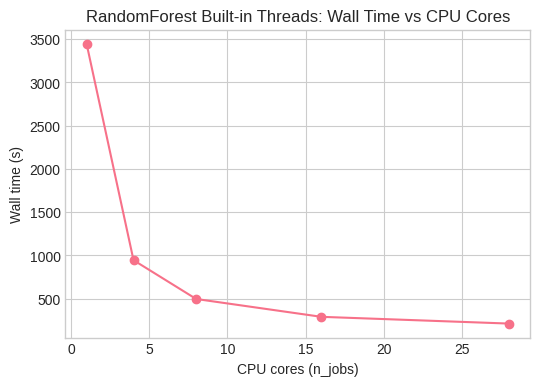

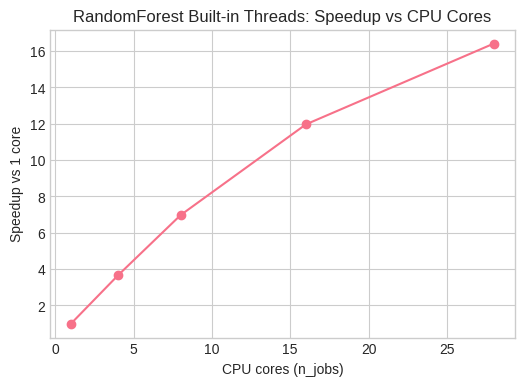

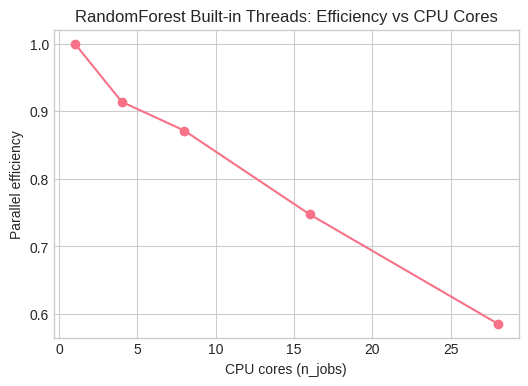

In [34]:
df_thr = results_df_rf_thread.sort_values("cpus").copy()

# 1) Wall time vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["time_sec"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Wall time (s)")
plt.title("RandomForest Built-in Threads: Wall Time vs CPU Cores")
plt.grid(True)
plt.show()

# 2) Speedup vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["speedup"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Speedup vs 1 core")
plt.title("RandomForest Built-in Threads: Speedup vs CPU Cores")
plt.grid(True)
plt.show()

# 3) Parallel efficiency vs CPU cores
plt.figure(figsize=(6, 4))
plt.plot(df_thr["cpus"], df_thr["efficiency"], marker="o")
plt.xlabel("CPU cores (n_jobs)")
plt.ylabel("Parallel efficiency")
plt.title("RandomForest Built-in Threads: Efficiency vs CPU Cores")
plt.grid(True)
plt.show()

In [35]:
best_rows_rf = []

best_rows_rf.append(
    pick_best(results_df_rf_thread, time_col="time_sec",
              label="RF – built-in threads (n_jobs)")
)

best_rows_rf.append(
    pick_best(results_df_joblib_rf, time_col="cv_time_sec",
              label="RF – Joblib process-based (loky CV)")
)

best_rows_rf.append(
    pick_best(results_df_joblib_builtin_rf, time_col="cv_time_sec",
              label="RF – Joblib built-in CV (n_jobs)")
)

best_rows_rf.append(
    pick_best(results_df_dask_rf, time_col="time_sec",
              label="RF – Dask-backed")
)

summary_best_rf = pd.DataFrame(best_rows_rf)
summary_best_rf

,method,best_cpus,best_wall_time,best_speedup,best_efficiency
0,RF – built-in threads (n_jobs),28,210.215809,16.402381,0.585799
1,RF – Joblib process-based (loky CV),8,2411.772300,2.779076,0.347384
2,RF – Joblib built-in CV (n_jobs),28,2395.730965,2.792296,0.099725
3,RF – Dask-backed,28,220.712180,16.041348,0.572905


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pick the *overall* best row (min wall time) in each algorithm
best_xgb_row = summary_best_xgb.loc[summary_best_xgb["best_wall_time"].idxmin()]
best_rf_row  = summary_best_rf.loc[summary_best_rf["best_wall_time"].idxmin()]

best_overall = pd.DataFrame([
    {
        "algorithm": "XGBoost",
        "method": best_xgb_row["method"],
        "cpus": int(best_xgb_row["best_cpus"]),
        "wall_time": float(best_xgb_row["best_wall_time"]),
        "speedup": float(best_xgb_row["best_speedup"]),
        "efficiency": float(best_xgb_row["best_efficiency"]),
    },
    {
        "algorithm": "Random Forest",
        "method": best_rf_row["method"],
        "cpus": int(best_rf_row["best_cpus"]),
        "wall_time": float(best_rf_row["best_wall_time"]),
        "speedup": float(best_rf_row["best_speedup"]),
        "efficiency": float(best_rf_row["best_efficiency"]),
    }
])

display(best_overall)

,algorithm,method,cpus,wall_time,speedup,efficiency
0,XGBoost,XGB – Dask distributed,8,42.465750,1.968955,0.246119
1,Random Forest,RF – built-in threads (n_jobs),28,210.215809,16.402381,0.585799


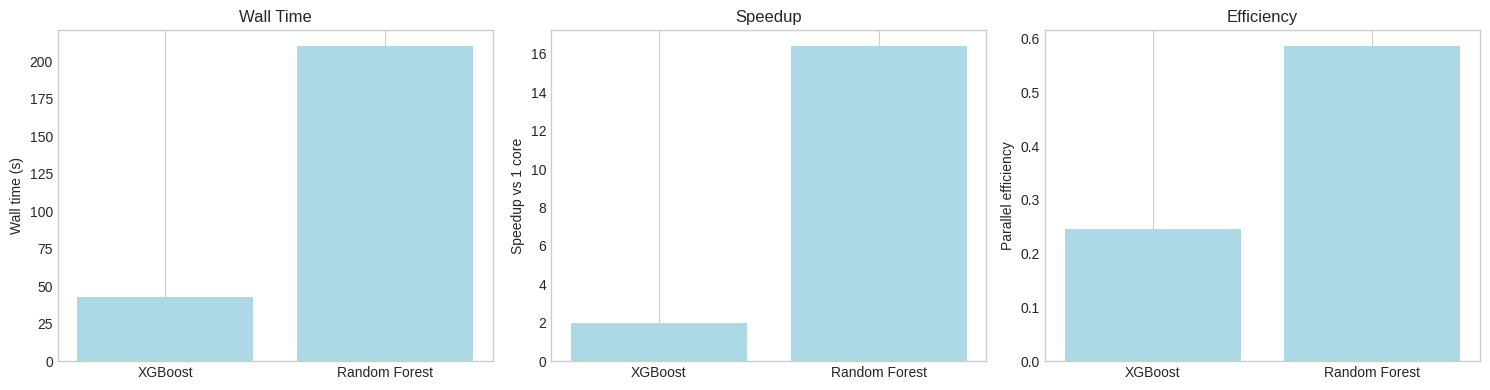

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# columns: algorithm, wall_time, speedup, efficiency
algos = best_overall["algorithm"].tolist()
x = np.arange(len(algos))

plt.figure(figsize=(15, 4))

# 1) Wall time
ax1 = plt.subplot(1, 3, 1)
ax1.bar(x, best_overall["wall_time"], color="lightblue")
ax1.set_xticks(x)
ax1.set_xticklabels(algos, rotation=0)
ax1.set_ylabel("Wall time (s)")
ax1.set_title("Wall Time")
ax1.grid(axis="y")

# 2) Speedup
ax2 = plt.subplot(1, 3, 2)
ax2.bar(x, best_overall["speedup"], color="lightblue")
ax2.set_xticks(x)
ax2.set_xticklabels(algos, rotation=0)
ax2.set_ylabel("Speedup vs 1 core")
ax2.set_title("Speedup")
ax2.grid(axis="y")

# 3) Efficiency
ax3 = plt.subplot(1, 3, 3)
ax3.bar(x, best_overall["efficiency"], color="lightblue")
ax3.set_xticks(x)
ax3.set_xticklabels(algos, rotation=0)
ax3.set_ylabel("Parallel efficiency")
ax3.set_title("Efficiency")
ax3.grid(axis="y")

plt.tight_layout()
plt.show()

<h2>Summary</h2>
<h3>XGBoost – best configuration</h3>

1. Among all XGBoost parallelization strategies, the fastest configuration is XGB – Dask distributed with 8 CPUs, achieving a wall time of ~42.5 s, compared to ~71.6 s for the 1-core baseline.<br>
2. This best XGBoost run reaches a speedup of ~2.0× and parallel efficiency of ~0.25, showing that Dask distributed training reduces overall runtime but also introduces scheduling/communication overhead that limits efficiency beyond a few workers.<br>
3. In contrast, Joblib built-in CV with 4 CPUs has the highest efficiency (0.65) among parallel XGBoost methods, but its wall time (~62.8 s) is still slower than Dask, highlighting a trade-off between “clean scaling” and absolute runtime.

<h3>Random Forest – best configuration</h3>

1. For Random Forest, the best wall time is obtained with RF – built-in threads using 28 CPUs, which finishes in ~210.2 s, much faster than the Joblib CV and Dask-backed configurations (2,200–2,400+ s).<br>
2. This configuration achieves an impressive speedup of ~16.4× over the 1-core RF baseline with a parallel efficiency of ~0.59, indicating that Random Forest’s tree building parallelizes very well with simple thread-based parallelism on this dataset.<br>
3. The RF Dask-backed approach is close (wall time ~220.7 s, speedup ~16.0×, efficiency ~0.57), confirming that both thread-based and Dask-backed RF scale efficiently, but pure n_jobs threads are slightly faster end-to-end.

<h3>XGBoost vs Random Forest (best configs)</h3>

Comparing the best overall configurations, XGBoost (Dask, 8 CPUs) is about 5× faster in wall time than Random Forest (threads, 28 CPUs): ~42.5 s vs ~210.2 s on the same wildfire dataset.<br>

However, Random Forest shows much higher scaling: its best run reaches ~16.4× speedup and ~0.59 efficiency, whereas the best XGBoost run reaches ~2.0× speedup and ~0.25 efficiency, illustrating that RF has a larger parallel fraction but a heavier overall workload, while XGBoost is more compute-efficient in absolute time.